<center><h3> <i> Code for the paper</i></h3>
<h2> Explaining Socio-demographic and Behavioral Patterns of Vaccination against the Swine Flu (H1N1) Pandemic


## Preparation part

*   Installing the required libraries & cloning the XAI github repository
*   Including all the libraries needed
*   Mounting the Google Drive - Uploding the dataset
*   Exploring the dataset with some visualisations & checking statistics





In [ ]:
!pip install catboost scikit-multilearn shap bitarray deap interpret aix360 pytorch-tabnet category_encoders

In [ ]:
!git clone https://github.com/francescanaretto/XAI-course_2021

Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 3894, done.
remote: Counting objects: 100% (1341/1341), done.
remote: Compressing objects: 100% (1325/1325), done.
remote: Total 3894 (delta 22), reused 1330 (delta 16), pack-reused 2553
Receiving objects: 100% (3894/3894), 1005.73 MiB | 36.83 MiB/s, done.
Resolving deltas: 100% (312/312), done.
Updating files: 100% (3178/3178), done.


In [ ]:
cd XAI-course_2021/Tabular

/content/XAI-course_2021/Tabular


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import torch
from tqdm import tqdm_notebook as tqdm

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, recall_score, accuracy_score
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, make_scorer, hamming_loss, log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain
import sklearn.cluster as cl
from skmultilearn.model_selection import IterativeStratification
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
import scipy.cluster.hierarchy as shc

# Classifiers
from catboost import CatBoostClassifier, Pool
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE

# XAI
import lime
import shap

# XAI Library - LORE
from xailib.explainers.lime_explainer import LimeXAITabularExplainer
from xailib.explainers.lore_explainer import LoreTabularExplainer
from xailib.explainers.shap_explainer_tab import ShapXAITabularExplainer
from xailib.data_loaders.dataframe_loader import prepare_dataframe
from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

# XAI metrics 
from aix360.metrics import faithfulness_metric, monotonicity_metric

# libraries to make plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
cd ../..

/content


# Custoom functions

In [ ]:
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    # Iteratively stratify a multi-label data set into folds
    # the stratifier splits the dataset into folds trying to maintain balanced representation with respect to order-th label combinations.
    # order = 1 means independence among class labels
    # order = 2 considers correlations between a pair of class labels
    # order > 2 consider correlations among all the class labels or subsets of class labels
    # http://proceedings.mlr.press/v74/szyma%C5%84ski17a/szyma%C5%84ski17a.pdf

    stratifier = IterativeStratification(
        n_splits=2, 
        order=2, 
        sample_distribution_per_fold=[1.0-train_size, train_size] # desired percentage of samples in each of the folds
      )   

    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    return X_train, X_test, y_train, y_test

In [ ]:
def get_catboost_pred(X_eval, y_eval, best_clf):
  preds_proba = best_clf.predict_proba(X_eval.values) # array-like of shape (n_samples, n_classes)
  preds = best_clf.predict(X_eval.values)
  y_preds = pd.DataFrame(
      {
          "h1n1_vaccine": preds_proba[:, 0],
          "seasonal_vaccine": preds_proba[:, 1],
      },
      index = y_eval.index
    )
  y_preds_labels = pd.DataFrame(
      {
          "h1n1_vaccine": preds[:,0].astype(int),
          "seasonal_vaccine": preds[:,1].astype(int),
      },
      index = y_eval.index
    )
  return y_preds, y_preds_labels

In [27]:
def get_tabnet_pred(X_eval, y_eval, best_clf):
  preds_proba = best_clf.predict_proba(X_eval.values) # array-like of shape (n_samples, n_classes)
  preds = best_clf.predict(X_eval.values)
  y_preds = pd.DataFrame(
      {
          "h1n1_vaccine": preds_proba[:, 0],
          "seasonal_vaccine": preds_proba[:, 1],
      },
      index = y_eval.index
    )
  y_preds_labels = pd.DataFrame(
      {
          "h1n1_vaccine": preds[:,0].astype(int),
          "seasonal_vaccine": preds[:,1].astype(int),
      },
      index = y_eval.index
    )
  return y_preds, y_preds_labels

In [ ]:
def evaluate_predictions(y_preds, y_preds_labels, y_true):
  scores = dict()
  # multi-label and multi-task case
  if y_true.shape[1]>1:
    scores['roc_auc_macro'] = roc_auc_score(y_score=y_preds, y_true=y_true, average='macro')
    scores['roc_auc_micro'] = roc_auc_score(y_score=y_preds, y_true=y_true, average='micro')
    scores['roc_auc_weighted'] = roc_auc_score(y_score=y_preds, y_true=y_true, average='weighted')
    scores['recall_macro'] = recall_score(y_pred=y_preds_labels, y_true=y_true, average='macro')
    scores['recall_micro'] = recall_score(y_pred=y_preds_labels, y_true=y_true, average='micro')
    scores['recall_weighted'] = recall_score(y_pred=y_preds_labels, y_true=y_true, average='weighted')
    scores['f1_macro'] = f1_score(y_pred=y_preds_labels, y_true=y_true, average='macro')
    scores['f1_micro'] = f1_score(y_pred=y_preds_labels, y_true=y_true, average='micro')
    scores['f1_weighted'] = f1_score(y_pred=y_preds_labels, y_true=y_true, average='weighted')
    scores['accuracy'] = accuracy_score(y_true, y_preds_labels)
  return scores

In [ ]:
def cc_catboost_fit_predict_best(X_train, y_train, X_eval, y_eval, order_list):
  catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.09972,
    depth=5,
    l2_leaf_reg=3,
    random_strength=4,
    loss_function='Logloss', 
    od_wait=10, 
    od_type='Iter',
    eval_metric='F1'
  )

  # initialize Classifier Chain a single label catboost classifier
  catboost_chain = ClassifierChain(catboost_clf, order=order_list, random_state=0)

  # train
  catboost_chain.fit(X_train.values, y_train.values)#,**fit_params  )

  # predict
  single_catboost_preds, single_catboost_preds_labels = get_catboost_pred(X_eval, y_eval, catboost_chain)
  single_catboost_eval = evaluate_predictions(single_catboost_preds, single_catboost_preds_labels, y_eval)
  return single_catboost_eval, single_catboost_preds, catboost_chain

In [ ]:
def f1_by_thr(y_true, y_prob):
      f1s_list = []
      thres_list = []
      best_f1 = dict()
      for i in range(len(y_prob.columns)): # 0=h1n1, 1=seasonal
        # f1-score for single labels
        f1i, thresi = [], []
        y = y_prob.iloc[:,i]
        y = np.sort(y)[::-1]
        # binarize depending on threshold values
        for t in np.linspace(0,1,100):
          labs = y > t
          f1 = f1_score(y_true.iloc[:,i], labs)
          thresi.append(t)
          f1i.append(f1)
          best_f1[i] = (thresi[np.argmax(f1i)], max(f1i))     
        f1s_list.append(f1i)
        thres_list.append(thresi)

        multilabel_f1, multilabel_thr = [], [] 
        for t in np.linspace(0,1,100):
          labs = y_prob > t
          f1 = f1_score(y_true, labs, average='weighted')
          multilabel_thr.append(t)
          multilabel_f1.append(f1)
        best_f1['multilab'] = (multilabel_thr[np.argmax(multilabel_f1)], max(multilabel_f1))  

      return f1s_list, thres_list, multilabel_f1, multilabel_thr, best_f1

In [ ]:
def roc_by_thr(y_true, y_prob):
      roc_list = []
      thres_list = []
      best_roc = dict()
      for i in range(len(y_prob.columns)): # 0=h1n1, 1=seasonal
        # f1-score for single labels
        roci, thresi = [], []
        y = y_prob.iloc[:,i]
        y = np.sort(y)[::-1]
        # binarize depending on threshold values
        for t in np.linspace(0,1,100):
          labs = y > t
          roc = roc_auc_score(y_score=labs, y_true=y_true.iloc[:,i])
          thresi.append(t)
          roci.append(roc)
          best_roc[i] = (thresi[np.argmax(roci)], max(roci))     
        roc_list.append(roci)
        thres_list.append(thresi)

        multilabel_roc, multilabel_thr = [], [] 
        for t in np.linspace(0,1,100):
          labs = y_prob > t
          roc = roc_auc_score(y_score=labs, y_true=y_true)
          multilabel_thr.append(t)
          multilabel_roc.append(roc)
        best_roc['multilab'] = (multilabel_thr[np.argmax(multilabel_roc)], max(multilabel_roc))  

      return roc_list, thres_list, multilabel_roc, multilabel_thr, best_roc

In [ ]:
def get_merged_shap_values(X_eval, features_df, features_df_enc, nominal_cols, shap_values):
  
  #get number of unique categories for each feature 
  n_categories = dict()
  for feat in X_eval.columns:
    root_name = '_'.join(feat.split('_')[:-1])
    if root_name in nominal_cols:
      n = len([c for c in X_eval.columns if c.startswith(root_name)])
      n_categories[root_name]=n
    else:
      n_categories[feat]=1
  
  merged_shap_values = []
  for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(list(n_categories.values())))[:-1]
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    merged_shap_values.append(values_sum)

  merged_col_names = []
  for c in np.split(X_eval.columns , np.cumsum(list(n_categories.values())))[:-1]:
    if len(c)==1:
      merged_col_names.append(c[0])
    else:
      merged_col_names.append('_'.join(c[0].split('_')[:-1]))

  #replace shap values
  shap_values.values = np.array(merged_shap_values)

  #replace data with categorical feature values 
  features_df = features_df[merged_col_names]
  features_df_enc = features_df_enc[merged_col_names]
  shap_values.data = np.array(features_df_enc.iloc[X_eval.index])

  #update feature names
  shap_values.feature_names = merged_col_names
  # set display data with original categories
  shap_values.display_data = features_df.iloc[X_eval.index]
 
  
  return shap_values

In [ ]:
def label_encode(old_df, task_type='h1n1'):
  df = old_df.copy()
  df['census_msa'] = df['census_msa'].map({'Non-MSA': 0, 'MSA, Not Principle  City': 1, 'MSA, Principle City': 2})
  #df['age_group'] = df['age_group'].map({'18 - 34': 0, '35 - 44': 1, '45 - 54': 2, '55 - 64': 3, '65+': 4})
  df['age_group'] = df['age_group'].str.replace(' ','')
  df['age_group'] = df['age_group'].str.replace('Years','')
  df['age_group'] = df['age_group'].map({'18-34': 0, '35-44': 1, '45-54': 2, '55-64': 3, '65+': 4})
  df['education'] = df['education'].map({'< 12 Years': 0, '12 Years': 1, 'Some College': 2, 'College Graduate': 3})
  df['income_poverty'] = df['income_poverty'].map({'Below Poverty': 0, '<= $75,000, Above Poverty': 1, '> $75,000': 2})
  df['sex'] = df['sex'].map({'Female': 0, 'Male': 1})
  df['race'] = df['race'].map({'White': 0, 'Black': 1, 'Other or Multiple': 2, 'Hispanic': 3})
  df['marital_status'] = df['marital_status'].map({'Not Married': 0, 'Married': 1})
  df['rent_or_own'] = df['rent_or_own'].map({'Own': 0, 'Rent': 1})
  df['employment_status'] = df['employment_status'].map({'Not in Labor Force':1, 'Employed':2, 'Unemployed':0})
  df['employment_industry'] = df['employment_industry'].map({i:k for i, k in enumerate(df.employment_industry.unique())})
  df['employment_occupation'] = df['employment_occupation'].map({i:k for i, k in enumerate(df.employment_occupation.unique())})
  df['hhs_geo_region'] = df['hhs_geo_region'].map({i:k for i, k in enumerate(df.hhs_geo_region.unique())})
  df['age_group'] = df.age_group.astype(str).str.replace('Years','')
  if task_type == 'base':
    df["risk_ofgettingsick_withoutvaccine"] = (df["opinion_h1n1_risk"] + df["opinion_seas_risk"])/2
    df["worry_ofgettingsick_fromvaccine"] = (df["opinion_h1n1_sick_from_vacc"] + df["opinion_seas_sick_from_vacc"])/2
    df["vaccination_effective"] = (df["opinion_seas_vacc_effective"] + df["opinion_h1n1_vacc_effective"]) / 2
    df["doctor_recc"] = (df["doctor_recc_h1n1"] + df["doctor_recc_seasonal"]) /2
    df = df.drop(columns=['opinion_h1n1_risk', 'opinion_seas_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_h1n1_vacc_effective', 'doctor_recc_h1n1', 'doctor_recc_seasonal'])
  return df

# Load data & preprocessing


**Uploding the preprocessed dataset (imputation, one-hot encoding for the categorical variables etc.)**

In [16]:
labels_df  = pd.read_csv("Data/training_set_labels.csv", index_col="respondent_id")
features_df  = pd.read_csv("Data/training_set_features.csv", index_col="respondent_id")
X_train  = pd.read_csv("Data/X_train.csv", index_col="respondent_id")
X_eval  = pd.read_csv("Data/X_eval.csv", index_col="respondent_id")
#clean_features_df  = pd.read_csv("Data/clean_train_test_df.csv", index_col="respondent_id")

y_train = labels_df[labels_df.index.isin(X_train.index)]
y_eval = labels_df[labels_df.index.isin(X_eval.index)]

## **Merging the features for the binary classification problem of getting vaccinated or not** 

In [17]:
binary_features = features_df.copy()
binary_features["risk_ofgettingsick_withoutvaccine"] = (binary_features["opinion_h1n1_risk"] + binary_features["opinion_seas_risk"])/2
binary_features["worry_ofgettingsick_fromvaccine"] = (binary_features["opinion_h1n1_sick_from_vacc"] + binary_features["opinion_seas_sick_from_vacc"])/2
binary_features["vaccination_effective"] = (binary_features["opinion_seas_vacc_effective"] + binary_features["opinion_h1n1_vacc_effective"]) / 2
binary_features["doctor_recc"] = (binary_features["doctor_recc_h1n1"] + binary_features["doctor_recc_seasonal"]) /2
binary_features = binary_features.drop(columns=['opinion_h1n1_risk', 'opinion_seas_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_h1n1_vacc_effective', 'doctor_recc_h1n1', 'doctor_recc_seasonal'])
labels_df["vaccination"] = labels_df["h1n1_vaccine"] | labels_df["seasonal_vaccine"]

# Classification

In [18]:
X_train_binary = X_train.copy()
X_eval_binary = X_eval.copy()
y_train_binary = y_train.copy()
y_eval_binary = y_eval.copy()
X_train_h1n1 = X_train.copy()
X_eval_h1n1 = X_eval.copy()
y_train_h1n1 = y_train.copy()
y_eval_h1n1 = y_eval.copy()

## Binary model

In [ ]:
X_train_binary["risk_ofgettingsick_withoutvaccine"] = (X_train_binary["opinion_h1n1_risk"] + X_train_binary["opinion_seas_risk"])/2
X_train_binary["worry_ofgettingsick_fromvaccine"] = (X_train_binary["opinion_h1n1_sick_from_vacc"] + X_train_binary["opinion_seas_sick_from_vacc"])/2
X_train_binary["vaccination_effective"] = (X_train_binary["opinion_seas_vacc_effective"] + X_train_binary["opinion_h1n1_vacc_effective"]) / 2
X_train_binary["doctor_recc"] = (X_train_binary["doctor_recc_h1n1"] + X_train_binary["doctor_recc_seasonal"]) /2
X_train_binary = X_train_binary.drop(columns=['opinion_h1n1_risk', 'opinion_seas_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_h1n1_vacc_effective', 'doctor_recc_h1n1', 'doctor_recc_seasonal'])
y_train_binary["vaccination"] = y_train_binary["h1n1_vaccine"] | y_train_binary["seasonal_vaccine"]
y_train_binary.drop(columns=['h1n1_vaccine','seasonal_vaccine'], inplace=True)

In [ ]:
X_eval_binary["risk_ofgettingsick_withoutvaccine"] = (X_eval_binary["opinion_h1n1_risk"] + X_eval_binary["opinion_seas_risk"])/2
X_eval_binary["worry_ofgettingsick_fromvaccine"] = (X_eval_binary["opinion_h1n1_sick_from_vacc"] + X_eval_binary["opinion_seas_sick_from_vacc"])/2
X_eval_binary["vaccination_effective"] = (X_eval_binary["opinion_seas_vacc_effective"] + X_eval_binary["opinion_h1n1_vacc_effective"]) / 2
X_eval_binary["doctor_recc"] = (X_eval_binary["doctor_recc_h1n1"] + X_eval_binary["doctor_recc_seasonal"]) /2
X_eval_binary = X_eval_binary.drop(columns=['opinion_h1n1_risk', 'opinion_seas_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_h1n1_vacc_effective', 'doctor_recc_h1n1', 'doctor_recc_seasonal'])
y_eval_binary["vaccination"] = y_eval_binary["h1n1_vaccine"] | y_eval_binary["seasonal_vaccine"]
y_eval_binary.drop(columns=['h1n1_vaccine','seasonal_vaccine'])
y_eval_binary.drop(columns=['h1n1_vaccine','seasonal_vaccine'], inplace=True)

### Model Training


1.   TabNet and CatBoost with k-fold CV
2.   Model evalution results



#### TabNet

In [ ]:
X = X_train_binary.iloc[:,:].to_numpy()
y = y_train_binary.to_numpy().squeeze()

kf = KFold(n_splits=5, shuffle=True)
predictions_array =[]
CV_score_array =[]
for train_index, test_index in kf.split(X):
   X_train, X_valid = X[train_index], X[test_index]
   y_train, y_valid = y[train_index], y[test_index]
   classifier = TabNetClassifier(verbose=1,
                                 seed=42,
                                 lambda_sparse=1e-4, 
                                 momentum=0.3, 
                                 clip_value=2., 
                                 optimizer_fn=torch.optim.AdamW, 
                                 optimizer_params=dict(lr=2e-2), 
                                 scheduler_params = {"gamma": 0.95,"step_size": 20},
                                 scheduler_fn=torch.optim.lr_scheduler.StepLR, 
                                 epsilon=1e-15)
   #classifier = TabNetMultiTaskClassifier(verbose=1,lambda_sparse=1e-4, momentum=0.3, clip_value=2., optimizer_fn=torch.optim.AdamW, optimizer_params=dict(lr=2e-2), scheduler_params = {"gamma": 0.95,"step_size": 20},scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15)
   classifier.fit(X_train=X_train, 
                  y_train=y_train, 
                  eval_set=[(X_valid, y_valid)], 
                  eval_metric = ["logloss"], 
                  patience=10, 
                  max_epochs=2000)
   
   CV_score_array.append(classifier.best_cost)
   #roc_auc_score(y, clf.predict_proba(X), multi_class='ovr')
   #predictions_array.append(np.expm1(classifier.predict(X_valid)))
#predictions = np.mean(predictions_array,axis=0)
tabnet_binary = classifier

In [ ]:
tabnet_binary.fit(X_train_binary.values,y_train_binary.vaccination)

In [ ]:
tabnet_bin_preds_proba = tabnet_binary.predict_proba(X_eval_binary.values) #probs for class 0 / 1
tabnet_bin_preds = tabnet_binary.predict(X_eval_binary.values)

In [ ]:
print('F1 score: ', round(f1_score(y_eval_binary, tabnet_bin_preds, average='weighted'), 2))
print('ROC AUC score: ', round(roc_auc_score(y_eval_binary, tabnet_bin_preds, average='weighted'), 2))
print(classification_report(y_eval_binary.vaccination, tabnet_bin_preds))

#### CatBoost

##### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import  GridSearchCV
cat_grid_params = dict(depth=list(range(3, 8, 2)),
        learning_rate=np.linspace(0.01,1,9),
        #iterations=[10,50,100,250,500],
        l2_leaf_reg=[4,5,8],
        random_strength=np.linspace(0.5,10,3)
        )

cat_clf = CatBoostClassifier(
        loss_function='Logloss',
        iterations=500,
        task_type="GPU"
)

cat_clf_gs = cat_clf.grid_search(cat_grid_params, X_train_binary, y_train_binary, cv=5)

In [ ]:
cat_clf_binary_best_params = cat_clf.get_params()

In [ ]:
cat_clf.fit(X_train_binary, y_train_binary)

In [ ]:
cat_bin_preds_proba = cat_clf.predict_proba(X_eval_binary) #probs for class 0 / 1
cat_bin_preds = cat_clf.predict(X_eval_binary)

In [ ]:
print(classification_report(y_eval_binary.vaccination, cat_bin_preds))

In [ ]:
round(f1_score(y_eval_binary, cat_bin_preds, average='weighted'), 2)

In [ ]:
roc_auc_score(y_eval_binary, cat_bin_preds)

In [ ]:
cat_naive = CatBoostClassifier(loss_function='Logloss', verbose=False)
cat_naive.fit(X_train_binary.values, y_train_binary.values)

In [ ]:
y_pred_naive = cat_naive.predict(X_train)
print(classification_report(y_train_binary, y_pred_naive))

In [ ]:
y_pred_test_naive = cat_naive.predict(X_eval_binary)
print(classification_report(y_eval_binary, y_pred_test_naive))

In [ ]:
round(f1_score(y_test, y_pred_test, average='weighted'), 2)

##### Best model

In [ ]:
X = X_train_binary.iloc[:,:].to_numpy()
y = y_train_binary.to_numpy().squeeze()

kf = KFold(n_splits=5, shuffle=True)
predictions_array =[]
CV_score_array =[]
for train_index, test_index in kf.split(X):
   X_train, X_valid = X[train_index], X[test_index]
   y_train, y_valid = y[train_index], y[test_index]
   classifier = CatBoostClassifier(
    iterations=500,
    learning_rate=0.2575,
    depth=5,
    l2_leaf_reg=8,
    random_strength=10,
    loss_function='Logloss' 
    #task_type='GPU'
  )
   classifier.fit(X_train, 
                  y_train 
                  )
   
   CV_score_array.append(classifier.best_score_)

cat_clf = classifier

In [ ]:
# fit
cat_clf.fit(X_train_binary.values, y_train_binary.values)#,**fit_params  )

# predict
cat_bin_preds_proba = cat_clf.predict_proba(X_eval_binary) #probs for class 0 / 1
cat_bin_preds = cat_clf.predict(X_eval_binary)


In [ ]:
print('F1 score: ', round(f1_score(y_eval_binary, cat_bin_preds, average='weighted'), 2))
print('ROC AUC score: ', round(roc_auc_score(y_eval_binary, cat_bin_preds, average='weighted'), 2))
print(classification_report(y_eval_binary, cat_bin_preds))

## H1N1 model

### Balance data

In [19]:
def get_multiclass_label(v1,v2):
  l = 0
  if (v1==0) & (v2==0):
    l = 0
  elif (v1==0) & (v2==1):
    l = 1
  elif (v1==1) & (v2==0):
    l = 2
  else:
    l = 3
  return l

In [20]:
# do upsampling on multiclass
y_train_h1n1_multiclass = pd.DataFrame({'target': y_train_h1n1.apply(lambda x: get_multiclass_label(x.h1n1_vaccine, x.seasonal_vaccine), axis=1)},
                                  index=y_train_h1n1.index)
# add original target columns to the training set
X_train_h1n1 = X_train_h1n1.merge(y_train_h1n1, on='respondent_id')

#### SMOTE
SMOTE algorithm applies KNN approach where it selects K nearest neighbors, joins them and creates the synthetic samples in the space:
- take the feature vectors and its nearest neighbors, 
- compute the distance between these vectors,
- the difference is multiplied by random number between (0, 1) and it is added back to feature.

In [21]:
# upsampling techniques are applied to the multiclass target 
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train_h1n1, y_train_h1n1_multiclass)
X_train_h1n1_smote = X_res.drop(columns=['h1n1_vaccine','seasonal_vaccine'])
y_train_h1n1_smote = X_res[['h1n1_vaccine','seasonal_vaccine']]
#X_train_h1n1.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'], inplace=True)
print(X_train_h1n1_smote.shape)
print(y_train_h1n1_smote.shape)

(42540, 93)
(42540, 2)


In [22]:
y_train_h1n1_smote.value_counts()

h1n1_vaccine  seasonal_vaccine
0             0                   10635
              1                   10635
1             0                   10635
              1                   10635
dtype: int64

#### ADASYN
ADASYN is based on the idea of adaptively generating minority data samples according to their distributions using K nearest neighbor. The algorithm adaptively updates the distribution and there are no assumptions made for the underlying distribution of the data. ADASYN uses a density distribution as a criterion to automatically decide the number of synthetic samples that must be generated for each minority sample by adaptively changing the weights of the different minority samples to compensate for the skewed distributions.

In [23]:
ad = ADASYN()
X_res, y_res = ad.fit_resample(X_train_h1n1, y_train_h1n1_multiclass)
X_train_h1n1_adasyn = X_res.drop(columns=['h1n1_vaccine','seasonal_vaccine'])
y_train_h1n1_adasyn = X_res[['h1n1_vaccine','seasonal_vaccine']]
#X_train_h1n1.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'], inplace=True)
print(X_train_h1n1_adasyn.shape)
print(y_train_h1n1_adasyn.shape)

(42502, 93)
(42502, 2)


In [24]:
y_train_h1n1_adasyn.value_counts()

h1n1_vaccine  seasonal_vaccine
1             1                   11327
0             0                   10635
1             0                   10601
0             1                    9939
dtype: int64

#### Random Oversampler
This naive algorithm randomly samples with replacement the current available samples

In [25]:
ros = RandomOverSampler()
X_res, y_res = ros.fit_resample(X_train_h1n1, y_train_h1n1_multiclass)
X_train_h1n1_randomOS = X_res.drop(columns=['h1n1_vaccine','seasonal_vaccine'])
y_train_h1n1_randomOS = X_res[['h1n1_vaccine','seasonal_vaccine']]
X_train_h1n1.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'], inplace=True)
print(X_train_h1n1_randomOS.shape)
print(y_train_h1n1_randomOS.shape)
print(y_train_h1n1_randomOS.value_counts())

(42540, 93)
(42540, 2)
h1n1_vaccine  seasonal_vaccine
0             0                   10635
              1                   10635
1             0                   10635
              1                   10635
dtype: int64


### Hyperparameters finetuning

#### CatBoost

In [ ]:
cat_grid_params = dict(depth=list(range(3, 8, 2)),
        learning_rate=np.linspace(0.01,1,9),
        iterations=[50,100,250],
        l2_leaf_reg=[4,5,8],
        random_strength=np.linspace(0.5,10,3)
        )

cat_clf = CatBoostClassifier(
        loss_function='MultiLogloss',
#        eval_metric='HammingLoss',
        iterations=500,
        class_names=['H1N1_vaccine', 'seasonal_vaccine'],
        od_type='Iter',
        od_wait=10,
        task_type="GPU"
)

cat_fit_params=dict(
            eval_metric='f1_weighted', 
 #           eval_set = test_pool,
            metric_period=10
           # verbose=50
)
cat_scoring = {#'hamming': make_scorer(hamming_loss, greater_is_better=False),
           'f1': 'f1_weighted',
           'acc': 'accuracy', 
           'rec': 'recall_weighted', 
           }

cat_grid = GridSearchCV(cat_clf, 
                          cat_grid_params,
                          #n_jobs=-1,
                          scoring = cat_scoring,
                          refit='f1',
                          cv=5           
                          )


# initialize Classifier Chain a single label catboost classifier
catboost_chain_10 = ClassifierChain(cat_clf, order=[1,0])

cat_grid_chain = GridSearchCV(catboost_chain_10, 
                          cat_grid_params,
                          #n_jobs=-1,
                          scoring = cat_scoring,
                          refit='f1',
                          cv=5,
                        
                          )


In [ ]:
cat_gridsearch = cat_grid.fit(X_train.values, y_train.values)#, **cat_fit_params)

In [ ]:
cat_gridsearch = cat_grid.fit(X_train_balanced.values, y_train_balanced.values, **cat_fit_params)

### Classifier Chain - TabNet

#### No oversampling

In [44]:
tabnet_best_cc = TabNetClassifier(gamma=1.2, 
  lambda_sparse=0.01, 
  momentum=0.6, 
  n_a=16, 
  n_d=32, 
  n_steps=12, 
  optimizer_params={'lr': 0.025}, 
  output_dim=2, 
  scheduler_params=0.95
)
tabnet_clf_h1n1 = ClassifierChain(tabnet_best_cc, order=[1,0], random_state=0)
tabnet_clf_h1n1.fit(X_train_h1n1, y_train_h1n1)

epoch 0  | loss: 1.38014 |  0:00:05s
epoch 1  | loss: 1.07779 |  0:00:09s
epoch 2  | loss: 0.97058 |  0:00:11s
epoch 3  | loss: 0.69785 |  0:00:14s
epoch 4  | loss: 0.72179 |  0:00:19s
epoch 5  | loss: 0.65772 |  0:00:22s
epoch 6  | loss: 0.62155 |  0:00:24s
epoch 7  | loss: 0.61178 |  0:00:27s
epoch 8  | loss: 0.58889 |  0:00:30s
epoch 9  | loss: 0.60407 |  0:00:33s
epoch 10 | loss: 0.60083 |  0:00:37s
epoch 11 | loss: 0.59957 |  0:00:40s
epoch 12 | loss: 0.59577 |  0:00:43s
epoch 13 | loss: 0.59145 |  0:00:45s
epoch 14 | loss: 0.60131 |  0:00:48s
epoch 15 | loss: 0.5943  |  0:00:52s
epoch 16 | loss: 0.58621 |  0:00:56s
epoch 17 | loss: 0.5805  |  0:00:58s
epoch 18 | loss: 0.57355 |  0:01:01s
epoch 19 | loss: 0.56021 |  0:01:03s
epoch 20 | loss: 0.5511  |  0:01:07s
epoch 21 | loss: 0.54353 |  0:01:11s
epoch 22 | loss: 0.53949 |  0:01:14s
epoch 23 | loss: 0.54299 |  0:01:16s
epoch 24 | loss: 0.54287 |  0:01:19s
epoch 25 | loss: 0.53397 |  0:01:22s
epoch 26 | loss: 0.53274 |  0:01:27s
e

ClassifierChain(base_estimator=TabNetClassifier(n_d=32,
                                                n_a=16,
                                                n_steps=12,
                                                gamma=1.2,
                                                cat_idxs=[],
                                                cat_dims=[],
                                                cat_emb_dim=1,
                                                n_independent=2,
                                                n_shared=2,
                                                epsilon=1e-15,
                                                momentum=0.6,
                                                lambda_sparse=0.01,
                                                seed=0,
                                                clip_value=1,
                                                verbose=1,
                                                optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                optimizer_params={'lr': 0.025},
                                                scheduler_fn=None,
                                                scheduler_params=0.95,
                                                mask_type='sparsemax',
                                                input_dim=None,
                                                output_dim=2,
                                                device_name='auto',
                                                n_shared_decoder=1,
                                                n_indep_decoder=1),
                order=[1, 0], random_state=0)

In [45]:
# tabnet_h1n1_preds_proba = tabnet_clf_h1n1.predict_proba(X_eval_h1n1.values) 
# tabnet_h1n1_preds = tabnet_clf_h1n1.predict(X_eval_h1n1.values)
tabnet_h1n1_preds_proba, tabnet_h1n1_preds = get_tabnet_pred(X_eval_h1n1, y_eval_h1n1, tabnet_clf_h1n1)

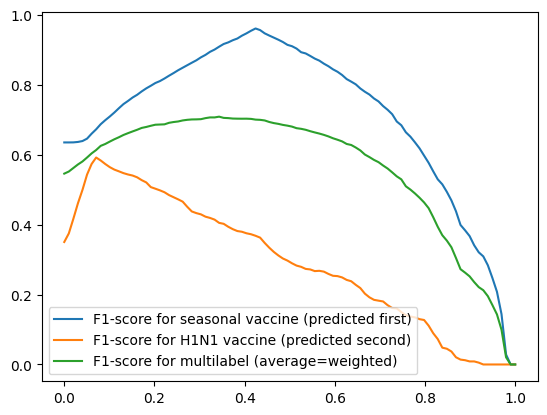

In [46]:
f1s_list, thres_list, multilabel_f1, multilabel_thr, best_f1 = f1_by_thr(y_eval_h1n1, pd.DataFrame(tabnet_h1n1_preds_proba))
plt.plot(thres_list[1], f1s_list[1], label='F1-score for seasonal vaccine (predicted first)')
plt.plot(thres_list[0], f1s_list[0], label='F1-score for H1N1 vaccine (predicted second)')
plt.plot(multilabel_thr, multilabel_f1, label='F1-score for multilabel (average=weighted)')
plt.legend()

In [47]:
# convert probs to binary label in the case of seasonal vaccine
y_preds_seasonal_tabnet = tabnet_h1n1_preds_proba['seasonal_vaccine'] > best_f1['multilab'][0] # seasonal has label index = 1
y_preds_seasonal_tabnet = y_preds_seasonal_tabnet.astype(int)
y_preds_h1n1_tabnet = tabnet_h1n1_preds_proba['h1n1_vaccine'] > best_f1['multilab'][0] # h1n1 has label index = 0
y_preds_h1n1_tabnet = y_preds_h1n1_tabnet.astype(int)

In [ ]:
print('F1 score: ', round(f1_score(y_eval_h1n1.h1n1_vaccine, y_preds_h1n1_tabnet, average='weighted'), 2))
print('ROC AUC score: ', round(roc_auc_score(y_eval_h1n1.h1n1_vaccine, y_preds_h1n1_tabnet, average='weighted'), 2))
print(classification_report(y_eval_h1n1.h1n1_vaccine, y_preds_h1n1_tabnet))

#### SMOTE

In [37]:
tabnet_clf_h1n1_smote = ClassifierChain(tabnet_best_cc, order=[1,0], random_state=0)
tabnet_clf_h1n1_smote.fit(X_train_h1n1_smote, y_train_h1n1_smote)
tabnet_h1n1_smote_preds_proba, tabnet_h1n1_smote_preds = get_tabnet_pred(X_eval_h1n1, y_eval_h1n1, tabnet_clf_h1n1_smote)
f1s_list, thres_list, multilabel_f1, multilabel_thr, best_f1 = f1_by_thr(y_eval_h1n1, pd.DataFrame(tabnet_h1n1_smote_preds_proba))
# convert probs to binary label in the case of seasonal vaccine
y_preds_seasonal_tabnet_smote = tabnet_h1n1_smote_preds_proba['seasonal_vaccine'] > best_f1['multilab'][0] # seasonal has label index = 1
y_preds_seasonal_tabnet_smote = y_preds_seasonal_tabnet_smote.astype(int)
y_preds_h1n1_tabnet_smote = tabnet_h1n1_smote_preds_proba['h1n1_vaccine'] > best_f1['multilab'][0] # h1n1 has label index = 0
y_preds_h1n1_tabnet_smote = y_preds_h1n1_tabnet_smote.astype(int)

epoch 0  | loss: 1.02482 |  0:00:15s
epoch 1  | loss: 0.70138 |  0:00:26s
epoch 2  | loss: 0.65242 |  0:00:34s
epoch 3  | loss: 0.60889 |  0:00:46s
epoch 4  | loss: 0.75391 |  0:00:57s
epoch 5  | loss: 0.59992 |  0:01:10s
epoch 6  | loss: 0.58364 |  0:01:24s
epoch 7  | loss: 0.57941 |  0:01:29s
epoch 8  | loss: 0.58666 |  0:01:35s
epoch 9  | loss: 0.56904 |  0:01:42s
epoch 10 | loss: 0.56392 |  0:01:48s
epoch 11 | loss: 0.56625 |  0:01:56s
epoch 12 | loss: 0.57787 |  0:02:07s
epoch 13 | loss: 0.56332 |  0:02:22s
epoch 14 | loss: 0.55583 |  0:02:30s
epoch 15 | loss: 0.5506  |  0:02:37s
epoch 16 | loss: 0.54848 |  0:02:43s
epoch 17 | loss: 0.56517 |  0:02:56s
epoch 18 | loss: 0.56087 |  0:03:11s
epoch 19 | loss: 0.55594 |  0:03:16s
epoch 20 | loss: 0.55555 |  0:03:22s
epoch 21 | loss: 0.54783 |  0:03:29s
epoch 22 | loss: 0.54823 |  0:03:35s
epoch 23 | loss: 0.54447 |  0:03:41s
epoch 24 | loss: 0.54111 |  0:03:51s
epoch 25 | loss: 0.53682 |  0:03:59s
epoch 26 | loss: 0.53777 |  0:04:06s
e

ADASYN

In [38]:
tabnet_clf_h1n1_adasyn = ClassifierChain(tabnet_best_cc, order=[1,0], random_state=0)
tabnet_clf_h1n1_adasyn.fit(X_train_h1n1_adasyn, y_train_h1n1_adasyn)
tabnet_h1n1_adasyn_preds_proba, tabnet_h1n1_adasyn_preds = get_tabnet_pred(X_eval_h1n1, y_eval_h1n1, tabnet_clf_h1n1_adasyn)
f1s_list, thres_list, multilabel_f1, multilabel_thr, best_f1 = f1_by_thr(y_eval_h1n1, pd.DataFrame(tabnet_h1n1_adasyn_preds_proba))
# convert probs to binary label in the case of seasonal vaccine
y_preds_seasonal_tabnet_adasyn = tabnet_h1n1_adasyn_preds_proba['seasonal_vaccine'] > best_f1['multilab'][0] # seasonal has label index = 1
y_preds_seasonal_tabnet_adasyn = y_preds_seasonal_tabnet_adasyn.astype(int)
y_preds_h1n1_tabnet_adasyn = tabnet_h1n1_adasyn_preds_proba['h1n1_vaccine'] > best_f1['multilab'][0] # h1n1 has label index = 0
y_preds_h1n1_tabnet_adasyn = y_preds_h1n1_tabnet_adasyn.astype(int)

epoch 0  | loss: 0.98617 |  0:00:05s
epoch 1  | loss: 0.79737 |  0:00:13s
epoch 2  | loss: 0.72729 |  0:00:18s
epoch 3  | loss: 0.67812 |  0:00:24s
epoch 4  | loss: 0.67466 |  0:00:31s
epoch 5  | loss: 0.654   |  0:00:37s
epoch 6  | loss: 0.62521 |  0:00:44s
epoch 7  | loss: 0.6203  |  0:00:50s
epoch 8  | loss: 0.6122  |  0:00:56s
epoch 9  | loss: 0.60814 |  0:01:04s
epoch 10 | loss: 0.60556 |  0:01:09s
epoch 11 | loss: 0.60277 |  0:01:15s
epoch 12 | loss: 0.60546 |  0:01:22s
epoch 13 | loss: 0.6054  |  0:01:28s
epoch 14 | loss: 0.60325 |  0:01:35s
epoch 15 | loss: 0.60385 |  0:01:41s
epoch 16 | loss: 0.60336 |  0:01:47s
epoch 17 | loss: 0.60445 |  0:01:55s
epoch 18 | loss: 0.60121 |  0:02:01s
epoch 19 | loss: 0.5995  |  0:02:07s
epoch 20 | loss: 0.6015  |  0:02:14s
epoch 21 | loss: 0.60086 |  0:02:20s
epoch 22 | loss: 0.59863 |  0:02:28s
epoch 23 | loss: 0.59704 |  0:02:33s
epoch 24 | loss: 0.59591 |  0:02:39s
epoch 25 | loss: 0.59533 |  0:02:47s
epoch 26 | loss: 0.59433 |  0:02:52s
e

#### Random Oversampling

In [39]:
tabnet_clf_h1n1_ros = ClassifierChain(tabnet_best_cc, order=[1,0], random_state=0)
tabnet_clf_h1n1_ros.fit(X_train_h1n1_randomOS, y_train_h1n1_randomOS)
tabnet_h1n1_ros_preds_proba, tabnet_h1n1_ros_preds = get_tabnet_pred(X_eval_h1n1, y_eval_h1n1, tabnet_clf_h1n1_ros)
f1s_list, thres_list, multilabel_f1, multilabel_thr, best_f1 = f1_by_thr(y_eval_h1n1, pd.DataFrame(tabnet_h1n1_ros_preds_proba))
# convert probs to binary label in the case of seasonal vaccine
y_preds_seasonal_tabnet_ros = tabnet_h1n1_ros_preds_proba['seasonal_vaccine'] > best_f1['multilab'][0] # seasonal has label index = 1
y_preds_seasonal_tabnet_ros = y_preds_seasonal_tabnet_ros.astype(int)
y_preds_h1n1_tabnet_ros = tabnet_h1n1_ros_preds_proba['h1n1_vaccine'] > best_f1['multilab'][0] # h1n1 has label index = 0
y_preds_h1n1_tabnet_ros = y_preds_h1n1_tabnet_ros.astype(int)

epoch 0  | loss: 0.8908  |  0:00:05s
epoch 1  | loss: 0.77129 |  0:00:12s
epoch 2  | loss: 0.64233 |  0:00:19s
epoch 3  | loss: 0.62233 |  0:00:25s
epoch 4  | loss: 0.60113 |  0:00:33s
epoch 5  | loss: 0.59499 |  0:00:38s
epoch 6  | loss: 0.57696 |  0:00:45s
epoch 7  | loss: 0.56909 |  0:00:52s
epoch 8  | loss: 0.56867 |  0:00:57s
epoch 9  | loss: 0.57    |  0:01:05s
epoch 10 | loss: 0.56547 |  0:01:11s
epoch 11 | loss: 0.55885 |  0:01:16s
epoch 12 | loss: 0.55637 |  0:01:24s
epoch 13 | loss: 0.56238 |  0:01:30s
epoch 14 | loss: 0.55094 |  0:01:36s
epoch 15 | loss: 0.54816 |  0:01:44s
epoch 16 | loss: 0.54546 |  0:01:49s
epoch 17 | loss: 0.53402 |  0:01:57s
epoch 18 | loss: 0.52095 |  0:02:03s
epoch 19 | loss: 0.51663 |  0:02:08s
epoch 20 | loss: 0.50851 |  0:02:16s
epoch 21 | loss: 0.51103 |  0:02:22s
epoch 22 | loss: 0.50961 |  0:02:28s
epoch 23 | loss: 0.51952 |  0:02:35s
epoch 24 | loss: 0.51138 |  0:02:40s
epoch 25 | loss: 0.53187 |  0:02:48s
epoch 26 | loss: 0.54485 |  0:02:54s
e

#### Comparison

Weighted average

In [43]:
for y in [y_preds_h1n1_tabnet, y_preds_h1n1_tabnet_ros, y_preds_h1n1_tabnet_smote, y_preds_h1n1_tabnet_adasyn]:
 # print('F1 score: ', round(f1_score(y_eval_h1n1.h1n1_vaccine, y_preds_h1n1_tabnet, average='weighted'), 2))
  print('F1 score: ', round(f1_score(y_eval_h1n1.h1n1_vaccine, y, average='weighted'), 2))
  print('ROC AUC score: ', round(roc_auc_score(y_eval_h1n1.h1n1_vaccine, y, average='weighted'), 2))
  print(classification_report(y_eval_h1n1.h1n1_vaccine, y))

F1 score:  0.82
ROC AUC score:  0.73
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4208
           1       0.60      0.56      0.58      1135

    accuracy                           0.83      5343
   macro avg       0.74      0.73      0.73      5343
weighted avg       0.82      0.83      0.82      5343

F1 score:  0.8
ROC AUC score:  0.75
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      4208
           1       0.52      0.66      0.58      1135

    accuracy                           0.80      5343
   macro avg       0.71      0.75      0.72      5343
weighted avg       0.82      0.80      0.80      5343

F1 score:  0.81
ROC AUC score:  0.71
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4208
           1       0.56      0.54      0.55      1135

    accuracy                           0.81      5343
   macro avg      

Macro average

In [50]:
for y in [y_preds_h1n1_tabnet, y_preds_h1n1_tabnet_ros, y_preds_h1n1_tabnet_smote, y_preds_h1n1_tabnet_adasyn]:
 # print('F1 score: ', round(f1_score(y_eval_h1n1.h1n1_vaccine, y_preds_h1n1_tabnet, average='weighted'), 2))
  print('F1 score: ', round(f1_score(y_eval_h1n1.h1n1_vaccine, y, average='macro'), 2))
  print('ROC AUC score: ', round(roc_auc_score(y_eval_h1n1.h1n1_vaccine, y, average='macro'), 2))
  print(classification_report(y_eval_h1n1.h1n1_vaccine, y))

F1 score:  0.73
ROC AUC score:  0.73
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4208
           1       0.60      0.56      0.58      1135

    accuracy                           0.83      5343
   macro avg       0.74      0.73      0.73      5343
weighted avg       0.82      0.83      0.82      5343

F1 score:  0.72
ROC AUC score:  0.75
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      4208
           1       0.52      0.66      0.58      1135

    accuracy                           0.80      5343
   macro avg       0.71      0.75      0.72      5343
weighted avg       0.82      0.80      0.80      5343

F1 score:  0.72
ROC AUC score:  0.71
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4208
           1       0.56      0.54      0.55      1135

    accuracy                           0.81      5343
   macro avg     

### Classifier Chain - CatBoost

#### No oversampling

In [51]:
eval_results, predicted_probs, clf = cc_catboost_fit_predict_best(X_train_h1n1, y_train_h1n1, X_eval_h1n1, y_eval_h1n1, [1,0])

0:	learn: 0.7434496	total: 65.1ms	remaining: 32.5s
1:	learn: 0.7162739	total: 88.4ms	remaining: 22s
2:	learn: 0.7297750	total: 103ms	remaining: 17s
3:	learn: 0.7404529	total: 127ms	remaining: 15.7s
4:	learn: 0.7424528	total: 155ms	remaining: 15.3s
5:	learn: 0.7428513	total: 179ms	remaining: 14.8s
6:	learn: 0.7415868	total: 205ms	remaining: 14.5s
7:	learn: 0.7412301	total: 232ms	remaining: 14.3s
8:	learn: 0.7418909	total: 255ms	remaining: 13.9s
9:	learn: 0.7449816	total: 319ms	remaining: 15.7s
10:	learn: 0.7453130	total: 357ms	remaining: 15.9s
11:	learn: 0.7450960	total: 384ms	remaining: 15.6s
12:	learn: 0.7464105	total: 402ms	remaining: 15.1s
13:	learn: 0.7460071	total: 418ms	remaining: 14.5s
14:	learn: 0.7463956	total: 439ms	remaining: 14.2s
15:	learn: 0.7470304	total: 459ms	remaining: 13.9s
16:	learn: 0.7475345	total: 479ms	remaining: 13.6s
17:	learn: 0.7495071	total: 497ms	remaining: 13.3s
18:	learn: 0.7504024	total: 516ms	remaining: 13.1s
19:	learn: 0.7507664	total: 546ms	remaining

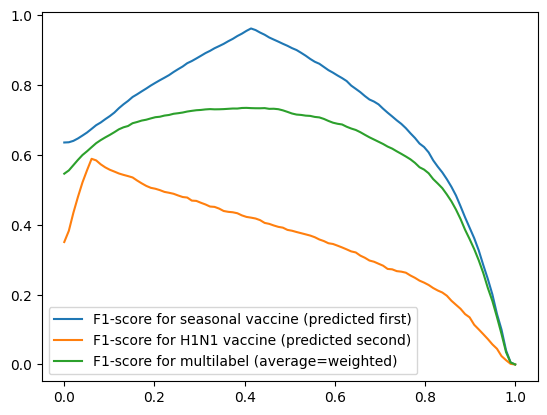

In [52]:
f1s_list, thres_list, multilabel_f1, multilabel_thr, best_f1 = f1_by_thr(y_eval_h1n1, predicted_probs)
plt.plot(thres_list[1], f1s_list[1], label='F1-score for seasonal vaccine (predicted first)')
plt.plot(thres_list[0], f1s_list[0], label='F1-score for H1N1 vaccine (predicted second)')
plt.plot(multilabel_thr, multilabel_f1, label='F1-score for multilabel (average=weighted)')
plt.legend()

In [53]:
best_f1

{0: (0.06060606060606061, 0.5885403163080114),
 'multilab': (0.4040404040404041, 0.7343214832437905),
 1: (0.4141414141414142, 0.9615310264836652)}

In [54]:
clf.estimators_[0].set_probability_threshold(best_f1['multilab'][0]) # seasonal
clf.estimators_[1].set_probability_threshold(best_f1['multilab'][0]) # H1N1
#.set_probability_threshold(0.275)
print(best_f1['multilab'][0])

0.4040404040404041


In [55]:
# convert probs to binary label in the case of seasonal vaccine
y_preds_seasonal = predicted_probs['seasonal_vaccine'] > best_f1['multilab'][0] # seasonal has label index = 1
y_preds_seasonal = y_preds_seasonal.astype(int)
y_preds_h1n1 = predicted_probs['h1n1_vaccine'] > best_f1['multilab'][0] # h1n1 has label index = 0
y_preds_h1n1 = y_preds_h1n1.astype(int)

In [56]:
print('H1N1 F1 score: ', round(f1_score(y_true=y_eval_h1n1.h1n1_vaccine, y_pred=y_preds_h1n1, average='weighted'), 2))
print('H1N1 ROC AUC score: ', round(roc_auc_score(y_true=y_eval_h1n1.h1n1_vaccine, y_score=y_preds_h1n1, average='weighted'), 2))
print(classification_report(y_eval_h1n1.h1n1_vaccine, y_preds_h1n1))

H1N1 F1 score:  0.85
H1N1 ROC AUC score:  0.77
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4208
           1       0.64      0.64      0.64      1135

    accuracy                           0.85      5343
   macro avg       0.77      0.77      0.77      5343
weighted avg       0.85      0.85      0.85      5343



#### SMOTE

In [57]:
eval_results, predicted_probs, clf = cc_catboost_fit_predict_best(X_train_h1n1_smote, y_train_h1n1_smote, X_eval_h1n1, y_eval_h1n1, [1,0])
f1s_list, thres_list, multilabel_f1, multilabel_thr, best_f1 = f1_by_thr(y_eval_h1n1, predicted_probs)
clf.estimators_[0].set_probability_threshold(best_f1['multilab'][0])
clf.estimators_[1].set_probability_threshold(best_f1['multilab'][0])
# convert probs to binary label in the case of seasonal vaccine
y_preds_seasonal_smote = predicted_probs['seasonal_vaccine'] > best_f1['multilab'][0] # seasonal has label index = 1
y_preds_seasonal_smote = y_preds_seasonal_smote.astype(int)
y_preds_h1n1_smote = predicted_probs['h1n1_vaccine'] > best_f1['multilab'][0] # h1n1 has label index = 0
y_preds_h1n1_smote = y_preds_h1n1_smote.astype(int)

0:	learn: 0.7376188	total: 11.5ms	remaining: 5.73s
1:	learn: 0.7341660	total: 22.4ms	remaining: 5.57s
2:	learn: 0.7367646	total: 33ms	remaining: 5.47s
3:	learn: 0.7256422	total: 45.9ms	remaining: 5.7s
4:	learn: 0.7305134	total: 57.6ms	remaining: 5.71s
5:	learn: 0.7294473	total: 72.8ms	remaining: 5.99s
6:	learn: 0.7371534	total: 85.1ms	remaining: 5.99s
7:	learn: 0.7413553	total: 98.1ms	remaining: 6.03s
8:	learn: 0.7430002	total: 109ms	remaining: 5.97s
9:	learn: 0.7440365	total: 120ms	remaining: 5.89s
10:	learn: 0.7444085	total: 131ms	remaining: 5.82s
11:	learn: 0.7442621	total: 139ms	remaining: 5.64s
12:	learn: 0.7446142	total: 149ms	remaining: 5.57s
13:	learn: 0.7470443	total: 163ms	remaining: 5.67s
14:	learn: 0.7475902	total: 178ms	remaining: 5.75s
15:	learn: 0.7488629	total: 189ms	remaining: 5.73s
16:	learn: 0.7494620	total: 200ms	remaining: 5.69s
17:	learn: 0.7495772	total: 214ms	remaining: 5.73s
18:	learn: 0.7515637	total: 225ms	remaining: 5.69s
19:	learn: 0.7527957	total: 236ms	re

#### ADASYN

In [58]:
eval_results, predicted_probs, clf = cc_catboost_fit_predict_best(X_train_h1n1_adasyn, y_train_h1n1_adasyn, X_eval_h1n1, y_eval_h1n1, [1,0])
f1s_list, thres_list, multilabel_f1, multilabel_thr, best_f1 = f1_by_thr(y_eval_h1n1, predicted_probs)
clf.estimators_[0].set_probability_threshold(best_f1['multilab'][0])
clf.estimators_[1].set_probability_threshold(best_f1['multilab'][0])
# convert probs to binary label in the case of seasonal vaccine
y_preds_seasonal_adasyn = predicted_probs['seasonal_vaccine'] > best_f1['multilab'][0] # seasonal has label index = 1
y_preds_seasonal_adasyn = y_preds_seasonal_adasyn.astype(int)
y_preds_h1n1_adasyn = predicted_probs['h1n1_vaccine'] > best_f1['multilab'][0] # h1n1 has label index = 0
y_preds_h1n1_adasyn = y_preds_h1n1_adasyn.astype(int)

0:	learn: 0.6876249	total: 28.7ms	remaining: 14.3s
1:	learn: 0.6950169	total: 59ms	remaining: 14.7s
2:	learn: 0.6947178	total: 86.7ms	remaining: 14.4s
3:	learn: 0.6945719	total: 112ms	remaining: 13.9s
4:	learn: 0.6944117	total: 127ms	remaining: 12.5s
5:	learn: 0.6921824	total: 170ms	remaining: 14s
6:	learn: 0.6993117	total: 199ms	remaining: 14s
7:	learn: 0.7003195	total: 227ms	remaining: 14s
8:	learn: 0.6992158	total: 254ms	remaining: 13.8s
9:	learn: 0.6979226	total: 281ms	remaining: 13.8s
10:	learn: 0.6985783	total: 308ms	remaining: 13.7s
11:	learn: 0.6997730	total: 330ms	remaining: 13.4s
12:	learn: 0.7004124	total: 358ms	remaining: 13.4s
13:	learn: 0.7016135	total: 383ms	remaining: 13.3s
14:	learn: 0.7031952	total: 414ms	remaining: 13.4s
15:	learn: 0.7038051	total: 445ms	remaining: 13.5s
16:	learn: 0.7052476	total: 473ms	remaining: 13.4s
17:	learn: 0.7051307	total: 500ms	remaining: 13.4s
18:	learn: 0.7059578	total: 534ms	remaining: 13.5s
19:	learn: 0.7047807	total: 560ms	remaining: 1

#### Random Oversampling

In [59]:
eval_results, predicted_probs, clf = cc_catboost_fit_predict_best(X_train_h1n1_randomOS, y_train_h1n1_randomOS, X_eval_h1n1, y_eval_h1n1, [1,0])
f1s_list, thres_list, multilabel_f1, multilabel_thr, best_f1 = f1_by_thr(y_eval_h1n1, predicted_probs)
clf.estimators_[0].set_probability_threshold(best_f1['multilab'][0])
clf.estimators_[1].set_probability_threshold(best_f1['multilab'][0])
# convert probs to binary label in the case of seasonal vaccine
y_preds_seasonal_ros = predicted_probs['seasonal_vaccine'] > best_f1['multilab'][0] # seasonal has label index = 1
y_preds_seasonal_ros = y_preds_seasonal_ros.astype(int)
y_preds_h1n1_ros = predicted_probs['h1n1_vaccine'] > best_f1['multilab'][0] # h1n1 has label index = 0
y_preds_h1n1_ros = y_preds_h1n1_ros.astype(int)

0:	learn: 0.7358928	total: 12.6ms	remaining: 6.29s
1:	learn: 0.7237945	total: 23.7ms	remaining: 5.89s
2:	learn: 0.7267616	total: 34.2ms	remaining: 5.67s
3:	learn: 0.7301897	total: 45.3ms	remaining: 5.62s
4:	learn: 0.7318226	total: 56.7ms	remaining: 5.62s
5:	learn: 0.7342279	total: 69.4ms	remaining: 5.71s
6:	learn: 0.7376832	total: 80.5ms	remaining: 5.67s
7:	learn: 0.7362398	total: 91.2ms	remaining: 5.61s
8:	learn: 0.7359940	total: 102ms	remaining: 5.55s
9:	learn: 0.7354741	total: 113ms	remaining: 5.52s
10:	learn: 0.7385670	total: 124ms	remaining: 5.5s
11:	learn: 0.7399848	total: 135ms	remaining: 5.47s
12:	learn: 0.7432624	total: 146ms	remaining: 5.46s
13:	learn: 0.7446985	total: 156ms	remaining: 5.42s
14:	learn: 0.7451630	total: 167ms	remaining: 5.41s
15:	learn: 0.7454898	total: 179ms	remaining: 5.41s
16:	learn: 0.7469720	total: 190ms	remaining: 5.4s
17:	learn: 0.7461720	total: 201ms	remaining: 5.39s
18:	learn: 0.7472028	total: 214ms	remaining: 5.41s
19:	learn: 0.7471199	total: 226ms	r

#### Comparison

In [60]:
for y in [y_preds_h1n1, y_preds_h1n1_ros, y_preds_h1n1_smote, y_preds_h1n1_adasyn]:
  print('F1 score: ', round(f1_score(y_eval_h1n1.h1n1_vaccine, y, average='weighted'), 2))
  print('ROC AUC score: ', round(roc_auc_score(y_eval_h1n1.h1n1_vaccine, y, average='weighted'), 2))
  print(classification_report(y_eval_h1n1.h1n1_vaccine, y))

F1 score:  0.85
ROC AUC score:  0.77
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4208
           1       0.64      0.64      0.64      1135

    accuracy                           0.85      5343
   macro avg       0.77      0.77      0.77      5343
weighted avg       0.85      0.85      0.85      5343

F1 score:  0.82
ROC AUC score:  0.79
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4208
           1       0.54      0.76      0.63      1135

    accuracy                           0.81      5343
   macro avg       0.73      0.79      0.75      5343
weighted avg       0.84      0.81      0.82      5343

F1 score:  0.84
ROC AUC score:  0.77
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4208
           1       0.62      0.64      0.63      1135

    accuracy                           0.84      5343
   macro avg     

Macro average

In [61]:
for y in [y_preds_h1n1, y_preds_h1n1_ros, y_preds_h1n1_smote, y_preds_h1n1_adasyn]:
  print('F1 score: ', round(f1_score(y_eval_h1n1.h1n1_vaccine, y, average='macro'), 2))
  print('ROC AUC score: ', round(roc_auc_score(y_eval_h1n1.h1n1_vaccine, y, average='macro'), 2))
  print(classification_report(y_eval_h1n1.h1n1_vaccine, y))

F1 score:  0.77
ROC AUC score:  0.77
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4208
           1       0.64      0.64      0.64      1135

    accuracy                           0.85      5343
   macro avg       0.77      0.77      0.77      5343
weighted avg       0.85      0.85      0.85      5343

F1 score:  0.75
ROC AUC score:  0.79
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4208
           1       0.54      0.76      0.63      1135

    accuracy                           0.81      5343
   macro avg       0.73      0.79      0.75      5343
weighted avg       0.84      0.81      0.82      5343

F1 score:  0.76
ROC AUC score:  0.77
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4208
           1       0.62      0.64      0.63      1135

    accuracy                           0.84      5343
   macro avg     

# Explanation Part


1.   TabNet - Explainable-by-design
2.   CatBoost - Blackbox model: SHAP, LIME, and LORE 


> Since CatBoost is a tree-based model we used the tree explainer of SHAP since it is fast.
> We can use the model agnostic explainer of SHAP which is kernel explainer but is really slow.




## Initialization of SHAP explainers

### Data preparation

In [ ]:
nominal_cols = ['race','employment_status','hhs_geo_region','employment_industry','employment_occupation']
clf_h1n1 = clf.estimators_[1]

# since the second chain predicts only the h1n1 label, we first add the pred column corresponding to the seasonal vaccine
X_eval_h1n1 = pd.merge(X_eval_h1n1, y_eval_h1n1['seasonal_vaccine'], on='respondent_id')
X_train_h1n1_with_seasonal = pd.merge(X_train_h1n1, y_train_h1n1['seasonal_vaccine'], on='respondent_id')
features_df['age_group'] = features_df['age_group'].str.replace('Years','')
features_df['health_insurance'] = features_df['health_insurance'].fillna(-1)
features_df_ext = pd.merge(features_df, pd.concat([y_train_h1n1['seasonal_vaccine'],y_eval_h1n1['seasonal_vaccine']]),on='respondent_id')
features_df_ext_enc = label_encode(features_df_ext)
X_eval_id_mapping = {old_id:i for i, old_id in enumerate(X_eval_h1n1.index)}

### H1N1 Shap Object

In [ ]:
expl_h1n1 = shap.TreeExplainer(clf_h1n1, 
                               #model_output="probability",
                               #data = X_train_h1n1_with_seasonal,
                               #feature_perturbation = 'tree_path_dependent',
                               #feature_perturbation='interventional'
                               )
shap_values_h1n1 = expl_h1n1.shap_values(X_eval_h1n1)
shap_values_h1n1_all_f = shap.Explanation(shap_values_h1n1, 
                                          feature_names=X_eval_h1n1.columns,
                                          base_values = np.tile(expl_h1n1.expected_value, shap_values_h1n1.shape[0]))
h1n1_merged_shap_values = get_merged_shap_values(X_eval_h1n1, 
                                                 features_df_ext, 
                                                 features_df_ext_enc, 
                                                 nominal_cols, 
                                                 shap_values_h1n1_all_f
                                                 )

#### Fidelity metric

In [ ]:
from tqdm import tqdm_notebook as tqdm
shap_preds = []
shap_base = h1n1_merged_shap_values.base_values[0]
for i in tqdm(range(X_eval_h1n1.shape[0])):
  # compute shap prediction: positive values correspond to probability higher than 0.5
  pred_i = shap_base + h1n1_merged_shap_values[i].values.sum()
  shap_prediction = 1 if pred_i > 0 else 0
  # compare with catboost predictions
  if y_preds_h1n1.iloc[i] == shap_prediction:
    shap_preds.append(1)
  else:
    shap_preds.append(0)

  0%|          | 0/5343 [00:00<?, ?it/s]

In [ ]:
print('Fidelity of SHAP explainer: ', round(np.array(shap_preds).sum()/X_eval_h1n1.shape[0],2))

Fidelity of SHAP explainer:  0.92


#### Faithfulness metric

In [ ]:
# H1N1
from tqdm import tqdm_notebook as tqdm
from aix360.metrics import faithfulness_metric, monotonicity_metric
ncases = X_eval_h1n1.shape[0]
fait = np.zeros(ncases)
base = np.zeros(ncases)
for i in tqdm(range(ncases)):
    predicted_class = clf_h1n1.predict(X_eval_h1n1.values[i].reshape(1,-1))[0]
    fait[i] = faithfulness_metric(clf_h1n1, X_eval_h1n1.values[i], shap_values_h1n1[i], base)

print("H1N1 Faithfulness metric mean: ", np.mean(fait))
print("H1N1 Faithfulness metric std. dev.:", np.std(fait))

Faithfulness metric mean:  0.22896608663927773
Faithfulness metric std. dev.: 0.5552126126057033


### Baseline Shap Object

In [ ]:
expl_base = shap.TreeExplainer(cat_clf)
shap_values_base = expl_base.shap_values(X_eval_binary)
shap_obj_base = expl_base(X_eval_binary)
shap_values_base_all_f = shap.Explanation(shap_values_base, 
                                          feature_names=X_eval_binary.columns,
                                          base_values = np.tile(expl_base.expected_value, shap_values_base.shape[0]))
binary_features['health_insurance'] = binary_features['health_insurance'].fillna(-1)
features_df_ext_enc_base = label_encode(binary_features)
base_merged_shap_values = get_merged_shap_values(X_eval_binary, 
                                                 binary_features, 
                                                 features_df_ext_enc_base, 
                                                 nominal_cols, 
                                                 shap_values_base_all_f
                                                 )

##### Faithfulness metrics

In [ ]:
# Baseline
ncases = X_eval_binary.shape[0]
fait = np.zeros(ncases)
base = np.zeros(ncases)
for i in tqdm(range(ncases)):
    predicted_class = cat_clf.predict(X_eval_binary.values[i].reshape(1,-1))[0]
    fait[i] = faithfulness_metric(cat_clf, X_eval_binary.values[i], shap_values_base[i], base)

print("H1N1 Faithfulness metric mean: ", np.mean(fait))
print("H1N1 Faithfulness metric std. dev.:", np.std(fait))

# Results

## 1. H1N1 Vaccine Hesitancy Model vs Baseline
Create a single plot for each model showong:
- SHAP values of best model (catboost)
- Feature importance returned by Catboost
- Feature importance returned by TabNet

#### CatBoost Feature Importance

##### Binary

In [ ]:
# The individual importance values for each of the input features 

# For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. 
# The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.
# default for non-ranking models
feature_importance_pred_value_change = cat_clf.get_feature_importance(data=Pool(X_eval_binary, y_eval_binary),
                                                    type="PredictionValuesChange",
                                                    prettified=True
                                                    )
# For each feature the value represents the difference between the loss value of the model with this feature and without it. 
# The model without this feature is equivalent to the one that would have been trained if this feature was excluded from the dataset.
# default for ranking models
feature_importance_loss_change = cat_clf.get_feature_importance(data=Pool(X_eval_binary, y_eval_binary),
                                                    type="LossFunctionChange",
                                                    prettified=True
                                                    )
catboost_feat_importance_binary = feature_importance_pred_value_change.merge(feature_importance_loss_change, on = 'Feature Id', suffixes=('_pred_value', '_loss_change'))

In [ ]:
catboost_feat_importance_binary.sort_values('Importances_pred_value', ascending=False).head(5)

,Feature Id,Importances_pred_value,Importances_loss_change
0,risk_ofgettingsick_withoutvaccine,13.230825,0.046461
1,vaccination_effective,9.792461,0.021648
2,doctor_recc,8.262150,0.024681
3,worry_ofgettingsick_fromvaccine,6.995199,0.007093
4,age_group,6.378803,0.016442


In [ ]:
catboost_feat_importance_binary.sort_values('Importances_loss_change', ascending=False).head(5)

,Feature Id,Importances_pred_value,Importances_loss_change
0,risk_ofgettingsick_withoutvaccine,13.230825,0.046461
2,doctor_recc,8.262150,0.024681
1,vaccination_effective,9.792461,0.021648
4,age_group,6.378803,0.016442
3,worry_ofgettingsick_fromvaccine,6.995199,0.007093


##### H1N1

In [ ]:
# The individual importance values for each of the input features 

# For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. 
# The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.
# default for non-ranking models
feature_importance_pred_value_change = clf_h1n1.get_feature_importance(data=Pool(X_eval_h1n1, y_eval_h1n1.h1n1_vaccine),
                                                    type="PredictionValuesChange",
                                                    prettified=True
                                                    )
# For each feature the value represents the difference between the loss value of the model with this feature and without it. 
# The model without this feature is equivalent to the one that would have been trained if this feature was excluded from the dataset.
# default for rankink models

feature_importance_loss_change = clf_h1n1.get_feature_importance(data=Pool(X_eval_h1n1, y_eval_h1n1.h1n1_vaccine),
                                                    type="LossFunctionChange",
                                                    prettified=True
                                                    )
catboost_feat_importance_h1n1 = feature_importance_pred_value_change.merge(feature_importance_loss_change, on = 'Feature Id', suffixes=('_pred_value', '_loss_change'))

In [ ]:
catboost_feat_importance_h1n1.sort_values('Importances_pred_value', ascending=False).head(5)

,Feature Id,Importances_pred_value,Importances_loss_change
0,seasonal_vaccine,14.391581,-0.004373
1,doctor_recc_h1n1,9.791667,0.034581
2,health_insurance,8.152101,0.018451
3,opinion_h1n1_risk,6.716215,0.014313
4,opinion_h1n1_vacc_effective,6.276056,0.010597


Text(0.5, 1.0, 'Feature Importance')

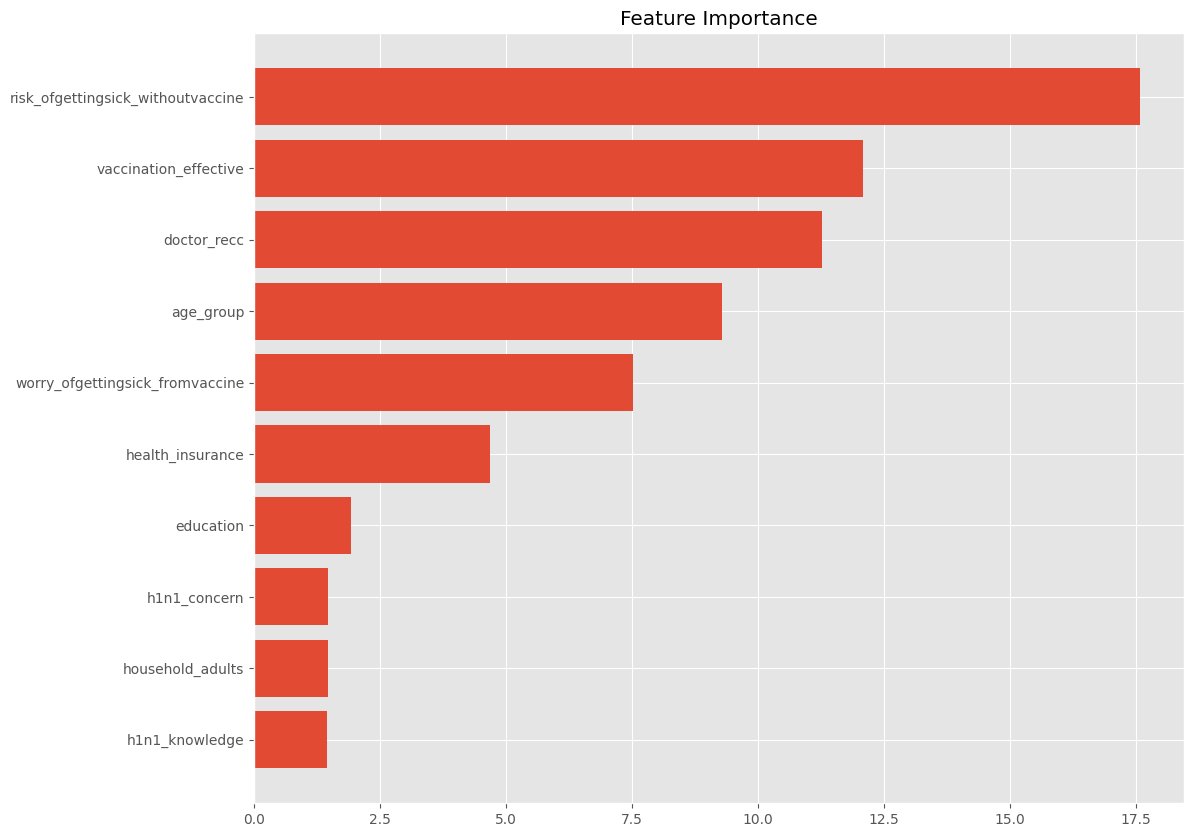

In [ ]:
feature_importance = cat_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_eval_binary.columns)[sorted_idx])
plt.title('Feature Importance')


#### TabNet Feature Importance


##### Binary

In [ ]:
tabnet_feat_importance_binary = [(i,j) for i,j in zip(X_train_binary.columns,  tabnet_binary.feature_importances_)]
tabnet_feat_importance_binary = pd.DataFrame(tabnet_feat_importance_binary, columns=['Feature Id', 'TabNet Importance'])

In [ ]:
tabnet_feat_importance_binary.sort_values('TabNet Importance', ascending=False).head(10)

,Feature Id,TabNet Importance
88,doctor_recc,0.198590
87,vaccination_effective,0.161521
13,age_group,0.117138
11,health_worker,0.091840
81,employment_occupation_xgwztkwe,0.084592
69,employment_occupation_hfxkjkmi,0.049555
46,employment_industry_ldnlellj,0.048508
68,employment_occupation_haliazsg,0.040814
60,employment_industry_xqicxuve,0.034810
2,behavioral_antiviral_meds,0.030351


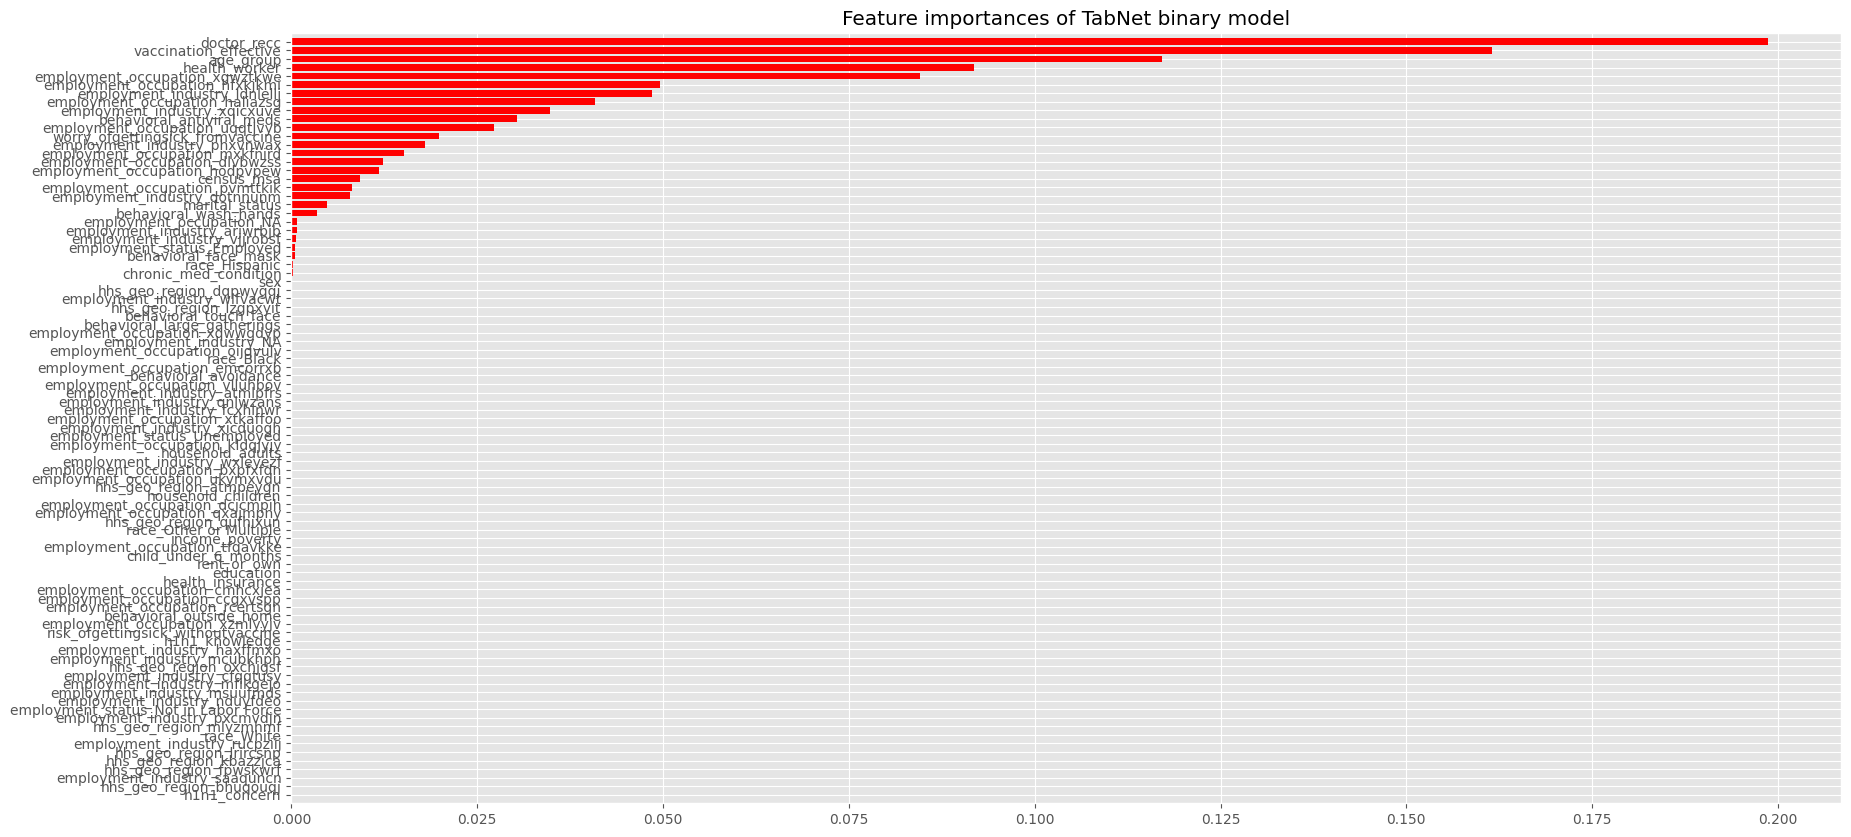

In [ ]:
#tabnet_binary.feature_importances_
tabnet_binary_importances = tabnet_binary.feature_importances_
tabnet_binary_indices = np.argsort(tabnet_binary_importances)

plt.figure()
plt.title("Feature importances of TabNet binary model")
plt.barh(range(len(tabnet_binary_importances)), tabnet_binary_importances[tabnet_binary_indices],
       color="r", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(len(tabnet_binary_importances)), [X_train_binary.columns[idx] for idx in tabnet_binary_indices])
plt.ylim([-1, len(tabnet_binary_importances)])
plt.show()

##### H1N1

In [ ]:
tabnet_feat_importance_h1n1 = [(i,j) for i,j in zip(X_train_h1n1.columns,  tabnet_clf_h1n1.estimators_[1].feature_importances_)]
tabnet_feat_importance_h1n1 = pd.DataFrame(tabnet_feat_importance_h1n1, columns=['Feature Id', 'TabNet Importance'])
tabnet_feat_importance_h1n1.sort_values('TabNet Importance', ascending=False).head(10)

,Feature Id,TabNet Importance
90,employment_occupation_xqwwgdyp,0.160599
9,doctor_recc_h1n1,0.082314
15,opinion_h1n1_vacc_effective,0.081039
46,employment_status_Unemployed,0.055499
65,employment_industry_wlfvacwt,0.055410
3,behavioral_avoidance,0.044636
38,hhs_geo_region_kbazzjca,0.037797
52,employment_industry_fcxhlnwr,0.033033
19,opinion_seas_risk,0.026780
63,employment_industry_saaquncn,0.023777


### Plots

#### Binary

In [ ]:
shap_feat_importance_binary = [(i,j) for i,j in zip(X_train_binary.columns, np.abs(shap_obj_base.values).mean(0))]
shap_feat_importance_binary = pd.DataFrame(shap_feat_importance_binary, columns=['Feature Id', 'SHAP Importance']).sort_values('SHAP Importance', ascending=False)

In [ ]:
global_expl_binary = shap_feat_importance_binary.merge(catboost_feat_importance_binary[['Feature Id','Importances_pred_value']], on='Feature Id')
global_expl_binary = global_expl_binary.merge(tabnet_feat_importance_binary, on='Feature Id')

In [ ]:
global_expl_binary.head()

,Feature Id,SHAP Importance,Importances_pred_value,TabNet Importance
0,risk_ofgettingsick_withoutvaccine,0.772698,13.230825,0.000000
1,doctor_recc,0.582936,8.262150,0.198590
2,vaccination_effective,0.480195,9.792461,0.161521
3,age_group,0.471789,6.378803,0.117138
4,health_insurance,0.342211,3.796326,0.000000


In [ ]:
# normalize columns
global_expl_binary['SHAP'] = MinMaxScaler().fit_transform(np.array(global_expl_binary['SHAP Importance']).reshape(-1,1))
global_expl_binary['Catboost'] = MinMaxScaler().fit_transform(np.array(global_expl_binary['Importances_pred_value']).reshape(-1,1))
global_expl_binary['TabNet'] = MinMaxScaler().fit_transform(np.array(global_expl_binary['TabNet Importance']).reshape(-1,1))
global_expl_binary.drop(columns=['SHAP Importance', 'Importances_pred_value', 'TabNet Importance'], inplace=True)

Text(0, 0.5, '')

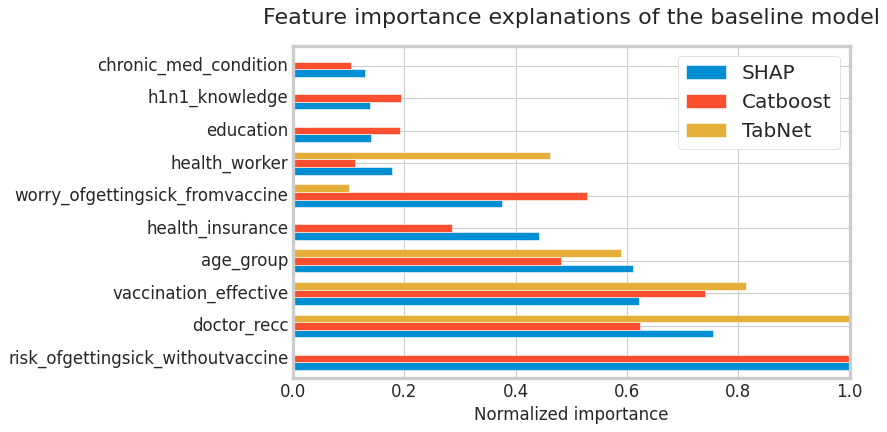

In [ ]:
# plot grouped bar chart
rc = {'figure.figsize':(8,5),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
      'font.family':'Times New Roman',
      'font.size' : 15}
plt.rcParams.update(rc)

sns.set_style("whitegrid")
#sns.despine(fig=True, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

global_expl_binary.sort_values('SHAP', ascending=False).head(10).plot(x='Feature Id',
        kind='barh',
        stacked=False,
        title='', 
        width=0.7)
plt.title('Feature importance explanations of the baseline model', fontsize = 20, pad=20)
plt.xlabel("Normalized importance", fontsize = 15)
plt.ylabel("")
#plt.style.use('fivethirtyeight')

#### H1N1

In [ ]:
shap_feat_importance_h1n1 = [(i,j) for i,j in zip(h1n1_merged_shap_values.feature_names, np.abs(h1n1_merged_shap_values.values).mean(0))]
shap_feat_importance_h1n1 = pd.DataFrame(shap_feat_importance_h1n1, columns=['Feature Id', 'SHAP Importance']).sort_values('SHAP Importance', ascending=False)

In [ ]:
[(i,j) for i,j in zip(X_train_h1n1.columns, np.mean(np.abs(h1n1_merged_shap_values.values), axis=0))]

In [ ]:
global_expl_h1n1 = shap_feat_importance_h1n1.merge(catboost_feat_importance_h1n1[['Feature Id','Importances_pred_value']], on='Feature Id', how='left')
global_expl_h1n1 = global_expl_h1n1.merge(tabnet_feat_importance_h1n1, on='Feature Id',how='left')

In [ ]:
global_expl_h1n1.sort_values('SHAP Importance', ascending=False).head()

,Feature Id,SHAP Importance,Importances_pred_value,TabNet Importance
0,seasonal_vaccine,0.911925,14.391581,NaN
1,health_insurance,0.624562,8.152101,0.005364
2,doctor_recc_h1n1,0.599466,9.791667,0.082314
3,opinion_h1n1_risk,0.446337,6.716215,0.014929
4,opinion_h1n1_vacc_effective,0.430851,6.276056,0.081039


In [ ]:
# normalize columns
global_expl_h1n1['SHAP'] = MinMaxScaler().fit_transform(np.array(global_expl_h1n1['SHAP Importance']).reshape(-1,1))
global_expl_h1n1['Catboost'] = MinMaxScaler().fit_transform(np.array(global_expl_h1n1['Importances_pred_value']).reshape(-1,1))
global_expl_h1n1['TabNet'] = MinMaxScaler().fit_transform(np.array(global_expl_h1n1['TabNet Importance']).reshape(-1,1))
global_expl_h1n1.drop(columns=['SHAP Importance', 'Importances_pred_value', 'TabNet Importance'], inplace=True)

Text(0, 0.5, '')

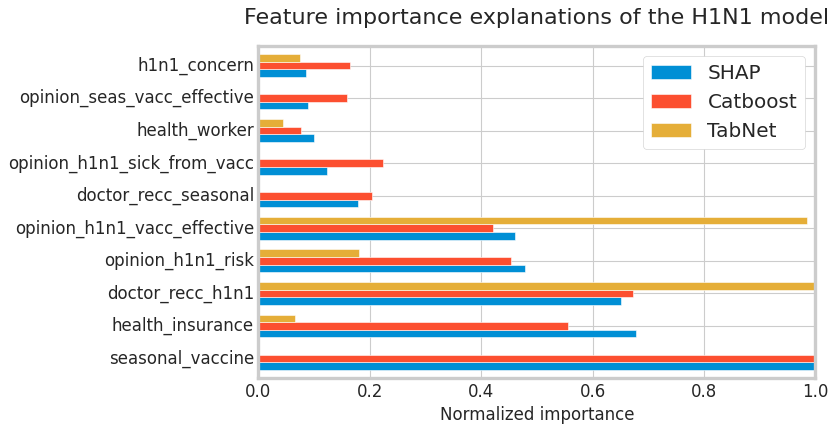

In [ ]:
# plot grouped bar chart
rc = {'figure.figsize':(8,5),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
      'font.family':'Times New Roman',
      'font.size' : 15}
plt.rcParams.update(rc)

sns.set_style("whitegrid")
#sns.despine(fig=True, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

global_expl_h1n1.sort_values('SHAP', ascending=False).head(10).plot(x='Feature Id',
        kind='barh',
        stacked=False,
        title='', 
        width=0.7)
plt.title('Feature importance explanations of the H1N1 model', fontsize = 20, pad=20)
plt.xlabel("Normalized importance", fontsize = 15)
plt.ylabel("")
#plt.style.use('fivethirtyeight')

## 2. Vaccine Hesitancy in High-risk Individuals
Here we're looking for ids such that:
- y_true = 0 (they did not vaccinate)
- y_pred = 0 (the model is correct)

### Highest risk (all categories)

In [ ]:
def get_shaps_and_miscl(map, shap_vals, df, highlight_feature):
  shaps = shap_vals.values[[map[i] for i in df.index],:]
  focus = df[highlight_feature]
  return shaps, focus

In [ ]:
ids_high_risk = X_eval_h1n1[
    ((X_eval_h1n1['chronic_med_condition'] == 1) & (X_eval_h1n1['age_group'] != 4)) # has chronic medical condition (c)
  & (X_eval_h1n1['age_group'] == 0) # age below 34 (d')
  & (X_eval_h1n1['health_worker'] == 1) # is health worker (b)
  & (X_eval_h1n1['child_under_6_months'] == 1) # is caregiver (a)
  ].index

In [ ]:
ids_high_risk

Int64Index([3148, 5359], dtype='int64', name='respondent_id')

In [ ]:
c1=3148
c2=5359

In [ ]:
y_eval.loc[ids_high_risk]#.merge(cat_bin_preds.loc[ids_high_risk], on='respondent_id', suffixes=('_true','_preds'))

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
3148,0,1
5359,1,1


In [ ]:
for i in ids_high_risk:
  print(i, features_df.loc[i]['race'], features_df.loc[i]['sex'], features_df.loc[i]['health_insurance'], features_df.loc[i]['age_group'],features_df.loc[i]['income_poverty'])

3148 Hispanic Female -1.0 18 - 34  <= $75,000, Above Poverty
5359 Hispanic Female 1.0 18 - 34  <= $75,000, Above Poverty


In [ ]:
df = y_eval_h1n1.loc[ids_high_risk].merge(y_preds_h1n1.loc[ids_high_risk], on='respondent_id', suffixes=('_true','_preds'))
df['focus'] = (df.h1n1_vaccine_true != df.h1n1_vaccine_preds)
# in the swapped version 0 = vaccinated, 1 = not vaccinated

In [ ]:
df

,h1n1_vaccine_true,seasonal_vaccine,h1n1_vaccine_preds,focus
respondent_id,,,,
3148,0,1,1,True
5359,1,1,1,False


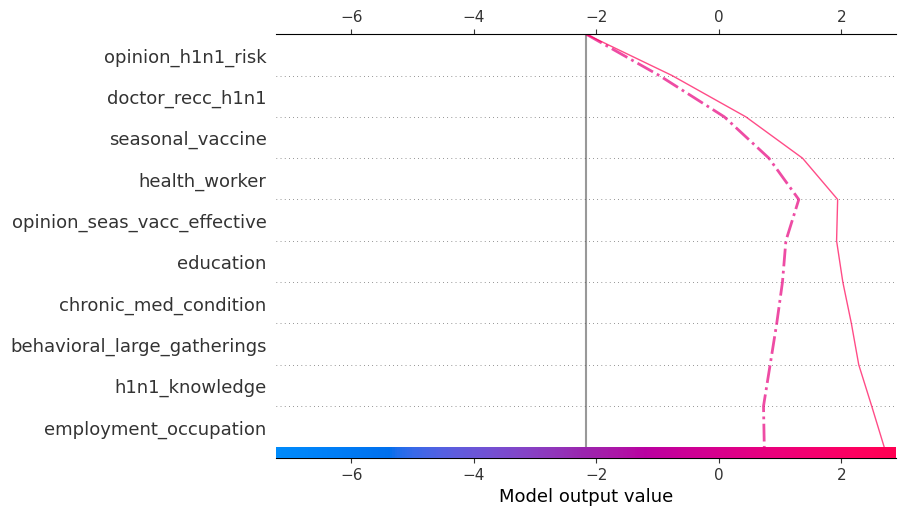

In [ ]:
shaps, focus = get_shaps_and_miscl(X_eval_id_mapping, h1n1_merged_shap_values, df, 'focus')
shap.decision_plot(expl_h1n1.expected_value, 
                   shaps,
                   #h1n1_merged_shap_values.values[[X_eval_id_mapping[i] for i in high_risk_young.index],:], 
                   feature_names=h1n1_merged_shap_values.feature_names,
                   highlight=focus,
                   #high_risk_young['misclassified'],
                   #link='logit',
                   feature_order='hclust',
                   alpha=0.7,
                   feature_display_range=range(0,10,1)
                   )

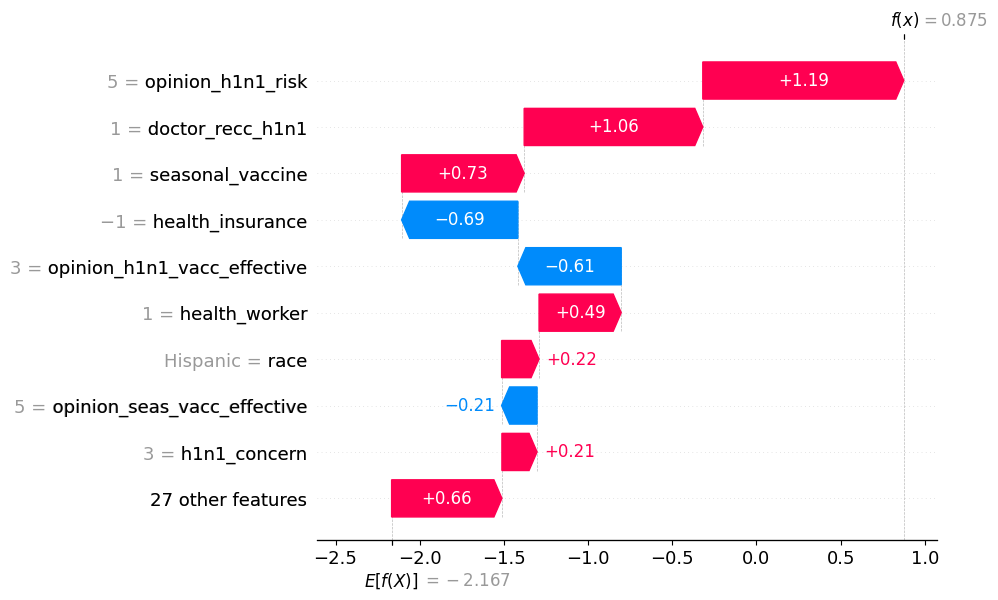

In [ ]:
shap.plots.waterfall(h1n1_merged_shap_values[X_eval_id_mapping[3148]], max_display=10)

### Relaxed assumptions - NO CAREGIVER

In [ ]:
ids_high_risk_2 = X_eval_h1n1[
    ((X_eval_h1n1['chronic_med_condition'] == 1) & (X_eval_h1n1['age_group'] != 4)) # has chronic medical condition (b)
  & (X_eval_h1n1['age_group'] == 0) # age below 34 (d')
  & (X_eval_h1n1['health_worker'] == 1) # is health worker (c)
#  & (X_eval_h1n1['child_under_6_months'] == 1) # is caregiver (b)
  ].index
df_2 = y_eval_h1n1.loc[ids_high_risk_2].merge(y_preds_h1n1.loc[ids_high_risk_2], on='respondent_id', suffixes=('_true','_preds'))
df_2['focus'] = (df_2.h1n1_vaccine_true == 0) & (df_2.h1n1_vaccine_preds == 0)
# 24085 = white, male, health insurance (-1) , 35-44, has chronic_med_condition, is health worker, is caregiver
# 25973 = white, female, health insurance (-1), 35-44 , has chronic_med_condition, is health worker, is caregiver
# 16609, 17203 = white, female, health insurance (-1), 18-34, has chronic_med_condition, is health worker, above poverty
# 19196 = black, female, has health insurance, 18-34, has chronic_med_condition, is health worker, above poverty
# 26425 = White, Female, has health insurance, 18-34, has chronic_med_condition, is health worker, above poverty
# 4346, 5723, 24491 = White, Male, health insurance (-1), 18-34, has chronic_med_condition, is health worker, above poverty

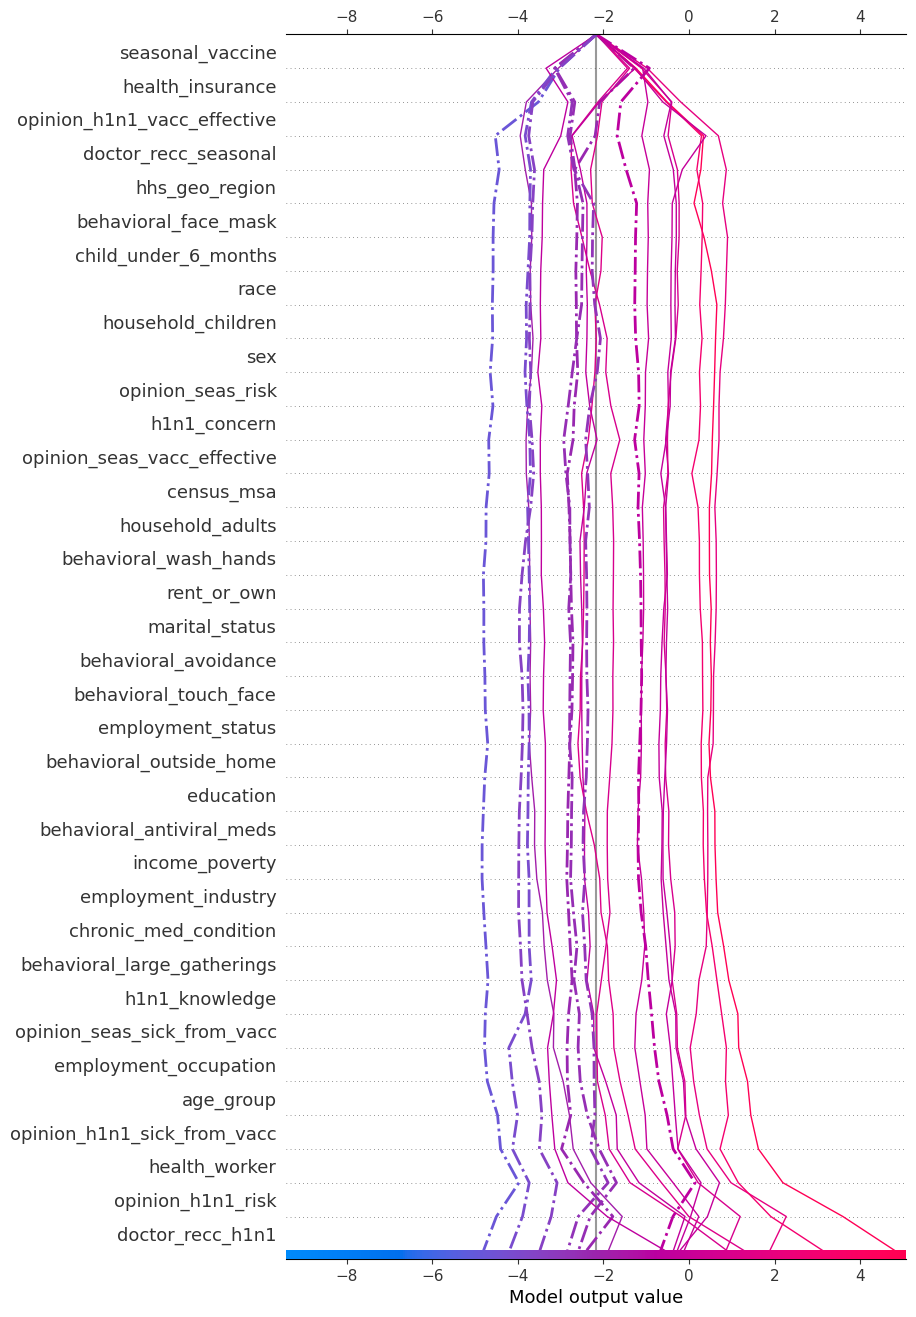

In [ ]:
shaps, focus = get_shaps_and_miscl(X_eval_id_mapping, h1n1_merged_shap_values, df_2, 'focus')
shap.decision_plot(expl_h1n1.expected_value, 
                   shaps,
                   feature_names=h1n1_merged_shap_values.feature_names,
                   highlight=focus,
                   feature_order='hclust',
                   #alpha=0.7,
                   feature_display_range=range(0,36,1)
                   )

In [ ]:
for i in ids_high_risk_2:
  print(i, features_df.loc[i]['race'], features_df.loc[i]['sex'], features_df.loc[i]['health_insurance'], features_df.loc[i]['age_group'],features_df.loc[i]['income_poverty'],)

159 White Female 0.0 18 - 34  Below Poverty
1031 White Female 1.0 18 - 34  <= $75,000, Above Poverty
1159 Black Female -1.0 18 - 34  Below Poverty
3148 Hispanic Female -1.0 18 - 34  <= $75,000, Above Poverty
4346 White Male -1.0 18 - 34  <= $75,000, Above Poverty
5359 Hispanic Female 1.0 18 - 34  <= $75,000, Above Poverty
5723 White Male -1.0 18 - 34  <= $75,000, Above Poverty
5807 Hispanic Female 1.0 18 - 34  > $75,000
6504 White Female 1.0 18 - 34  <= $75,000, Above Poverty
7906 White Female 1.0 18 - 34  > $75,000
8665 White Female 1.0 18 - 34  <= $75,000, Above Poverty
10081 White Female -1.0 18 - 34  nan
16039 White Female -1.0 18 - 34  > $75,000
16609 White Female -1.0 18 - 34  <= $75,000, Above Poverty
17203 White Female -1.0 18 - 34  <= $75,000, Above Poverty
19196 Black Female 1.0 18 - 34  <= $75,000, Above Poverty
23348 White Female 1.0 18 - 34  > $75,000
26425 White Female 1.0 18 - 34  <= $75,000, Above Poverty
24491 White Male -1.0 18 - 34  <= $75,000, Above Poverty


### Relaxed assumptions - NO HEALTH WORKER

In [ ]:
ids_high_risk_3 = X_eval_h1n1[
    ((X_eval_h1n1['chronic_med_condition'] == 1) & (X_eval_h1n1['age_group'] != 4)) # has chronic medical condition (b)
  & (X_eval_h1n1['age_group'] == 0) # age below 34 (d')
#  & (X_eval_h1n1['health_worker'] == 1) # is health worker (c)
  & (X_eval_h1n1['child_under_6_months'] == 1) # is caregiver (b)
  ].index
df_3 = y_eval_h1n1.loc[ids_high_risk_3].merge(y_preds_h1n1.loc[ids_high_risk_3], on='respondent_id', suffixes=('_true','_preds'))
df_3['focus'] = (df_3.h1n1_vaccine_true == 0) & (df_3.h1n1_vaccine_preds == 0)
# 8880 = Hispanic, Female, health insurance(-1), 18 - 34,  Below Poverty, has chronic_med_condition, is caregiver
# 16295 = Black, Female, health insurance(-1), 18 - 34,  <= $75,000, Above Poverty, has chronic_med_condition, is caregiver
# 23241 = Black, Female, health insurance(-1), 18 - 34, Below Poverty, has chronic_med_condition, is caregiver
# 24777 = White, Male, health insurance(-1), 18 - 34,  > $75,000, has chronic_med_condition, is caregiver

In [ ]:
c3, c4, c5, c6 = 8880, 16295, 23241, 24777

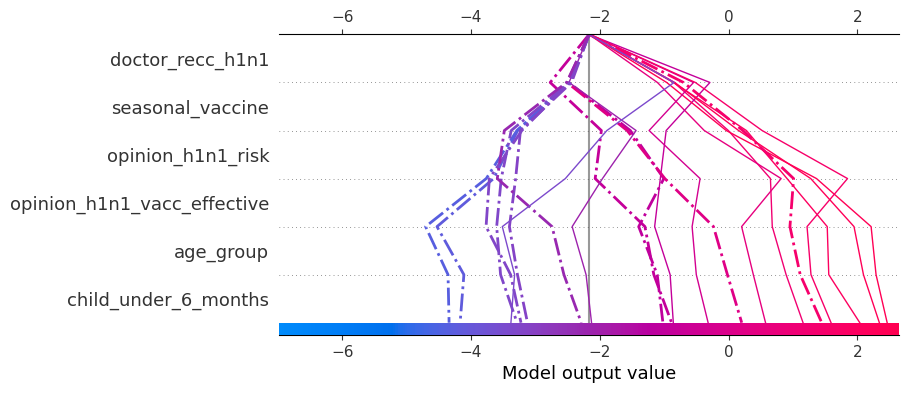

In [ ]:
shaps, focus = get_shaps_and_miscl(X_eval_id_mapping, h1n1_merged_shap_values, df_3, 'focus')
shap.decision_plot(expl_h1n1.expected_value, 
                   shaps,
                   #h1n1_merged_shap_values.values[[X_eval_id_mapping[i] for i in high_risk_young.index],:], 
                   feature_names=h1n1_merged_shap_values.feature_names,
                   highlight=focus,
                   #high_risk_young['misclassified'],
                   #link='logit',
                   feature_order='hclust',
                   #alpha=0.7,
                   feature_display_range=range(0,6,1)
                   )

### Doctor recommendation not effective

In [ ]:
ids_high_risk_4 = X_eval_h1n1[
    ((X_eval_h1n1['chronic_med_condition'] == 1) & (X_eval_h1n1['age_group'] != 4)) # has chronic medical condition (b)
  & (X_eval_h1n1['age_group'] == 0) # age below 34 (d')
#  & (X_eval_h1n1['health_worker'] == 1) # is health worker (c)
  & (X_eval_h1n1['child_under_6_months'] == 1) # is caregiver (b)
  & (X_eval_h1n1['doctor_recc_h1n1'] == 1)
  ].index
df_4 = y_eval_h1n1.loc[ids_high_risk_4].merge(y_preds_h1n1.loc[ids_high_risk_4], on='respondent_id', suffixes=('_true','_preds'))
df_4['focus'] = (df_4.h1n1_vaccine_true == 0) & (df_4.h1n1_vaccine_preds == 0)

In [ ]:
for i in ids_high_risk_4:
  print(i, features_df.loc[i]['race'], features_df.loc[i]['sex'], features_df.loc[i]['health_insurance'], features_df.loc[i]['age_group'],features_df.loc[i]['income_poverty'],)

1284 White Male -1.0 18 - 34  nan
3148 Hispanic Female -1.0 18 - 34  <= $75,000, Above Poverty
3348 White Female 0.0 18 - 34  <= $75,000, Above Poverty
3920 Hispanic Male 1.0 18 - 34  Below Poverty
5359 Hispanic Female 1.0 18 - 34  <= $75,000, Above Poverty
5934 White Female 1.0 18 - 34  <= $75,000, Above Poverty
10026 White Female 1.0 18 - 34  <= $75,000, Above Poverty
10121 White Female 1.0 18 - 34  <= $75,000, Above Poverty
10365 White Female -1.0 18 - 34  > $75,000
25198 Black Female 1.0 18 - 34  Below Poverty


In [ ]:
c7 = 10365

In [ ]:
df_4[df_4.focus == True]

,h1n1_vaccine_true,seasonal_vaccine,h1n1_vaccine_preds,focus
respondent_id,,,,
10365,0,1,0,True


### Doctor recommendation not effective + not caregiver

In [ ]:
ids_high_risk_5 = X_eval_h1n1[
    ((X_eval_h1n1['chronic_med_condition'] == 1) & (X_eval_h1n1['age_group'] != 4)) # has chronic medical condition (iii)
  & (X_eval_h1n1['age_group'] == 0) # age below 34 (iv)
#  & (X_eval_h1n1['health_worker'] == 1) # is health worker (ii)
#  & (X_eval_h1n1['child_under_6_months'] == 1) # is caregiver (i)
  & (X_eval_h1n1['doctor_recc_h1n1'] == 1)
  & (X_eval_h1n1['health_insurance'] == 1)
  ].index
df_5 = y_eval_h1n1.loc[ids_high_risk_5].merge(y_preds_h1n1.loc[ids_high_risk_5], on='respondent_id', suffixes=('_true','_preds'))
df_5['focus'] = (df_5.h1n1_vaccine_true == 0) & (df_5.h1n1_vaccine_preds == 0)
df_5[df_5.focus == True]

,h1n1_vaccine_true,seasonal_vaccine,h1n1_vaccine_preds,focus
respondent_id,,,,
4370,0,1,0,True
18533,0,0,0,True
24210,0,0,0,True
26541,0,0,0,True


In [ ]:
for i in [ids_high_risk_5]:
  print( features_df.loc[i]['race'], features_df.loc[i]['sex'], features_df.loc[i]['health_insurance'], features_df.loc[i]['age_group'],features_df.loc[i]['income_poverty'],)

In [ ]:
c8, c9 = 26541, 24210

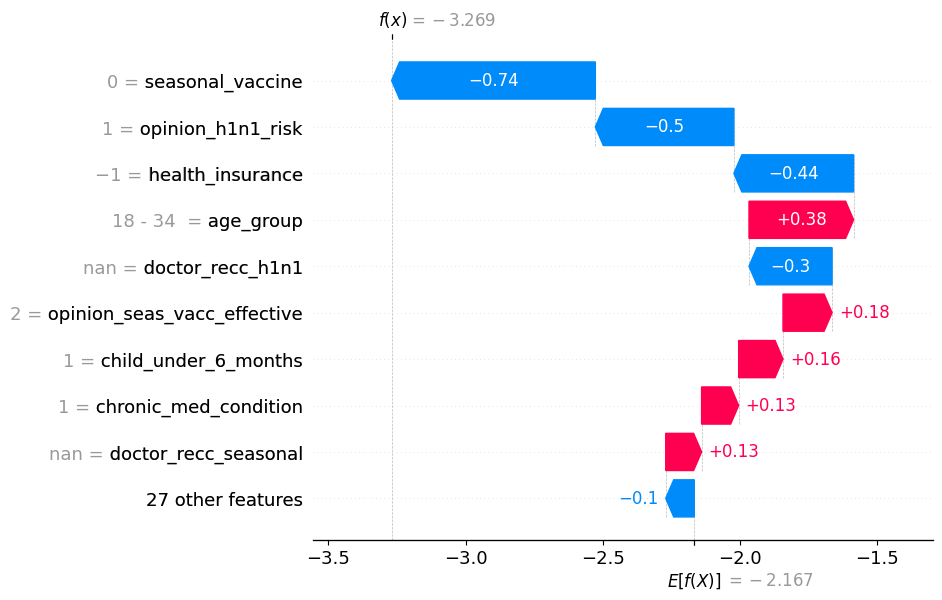

In [ ]:
shap.plots.waterfall(h1n1_merged_shap_values[X_eval_id_mapping[23241]], max_display=10)

#### Faithfulness (SHAP local)

In [ ]:
predicted_class = clf_h1n1.predict(X_eval_h1n1.values[j].reshape(1,-1))[0]
x = X_eval_h1n1.values[j]

base = np.zeros(x.shape[0])

print("Faithfulness: ", faithfulness_metric(clf_h1n1, x, shap_values_h1n1[j], base))
print("Monotonity: ", monotonicity_metric(clf_h1n1, x, shap_values_h1n1[j], base))

Faithfulness:  -0.48575650752648053
Monotonity:  False


### LIME (local)

In [ ]:
# add seasonal vaccine as a feature to train
X_train_h1n1_with_seasonal = X_train_h1n1.copy()
X_train_h1n1_with_seasonal['seasonal_vaccine'] = y_train_h1n1['seasonal_vaccine']
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_h1n1_with_seasonal.values, feature_names = X_train_h1n1_with_seasonal.columns)

In [ ]:
exp_lime = lime_explainer.explain_instance(X_eval_h1n1.values[X_eval_id_mapping[c5]], clf_h1n1.predict_proba)
exp_lime.show_in_notebook(show_table=False, show_all=True)

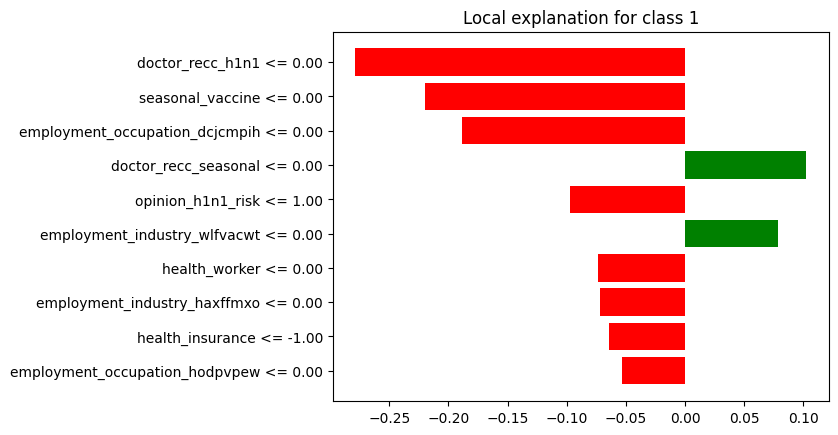

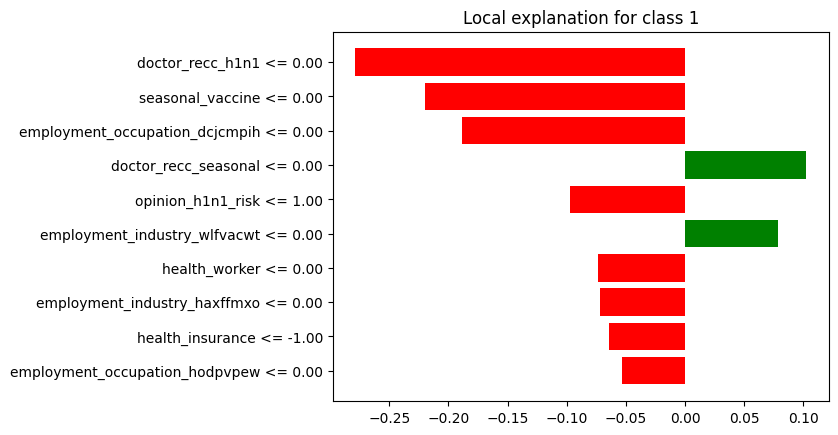

In [ ]:
exp_lime.as_pyplot_figure(label=1)

##### Fidelity

In [ ]:
from tqdm import tqdm_notebook as tqdm
lime_preds = []
for i in tqdm(range(X_eval_h1n1.shape[0])):
  # compute lime prediction: positive values correspond to probability higher than 0.5
  exp_lime = lime_explainer.explain_instance(X_eval_h1n1.values[i], clf_h1n1.predict_proba)
  lime_prediction = 0 if exp_lime.predict_proba[0] > 0.5 else 0
  # compare with catboost predictions
  if y_preds_h1n1.iloc[i] == lime_prediction:
    lime_preds.append(1)
  else:
    lime_preds.append(0)

  0%|          | 0/5343 [00:00<?, ?it/s]

In [ ]:
print('Fidelity of LIME explainer: ', round(np.array(lime_preds).sum()/X_eval_h1n1.shape[0],2))

Fidelity of LIME explainer:  0.79


In [ ]:
i = 23241
exp_lime = lime_explainer.explain_instance(X_eval_h1n1.loc[i], clf_h1n1.predict_proba)
lime_prediction = 0 if exp_lime.predict_proba[0] > 0.5 else 0
print('Fidelity of LIME explainer for instance', i, ':', y_preds_h1n1.loc[i] == lime_prediction)

Fidelity of LIME explainer for instance 23241 : True


In [ ]:
i = 24210
exp_lime = lime_explainer.explain_instance(X_eval_h1n1.loc[i], clf_h1n1.predict_proba)
lime_prediction = 0 if exp_lime.predict_proba[0] > 0.5 else 0
print('Fidelity of LIME explainer for instance', i, ':', y_preds_h1n1.loc[i] == lime_prediction)

Fidelity of LIME explainer for instance 24210 : True


##### Faithfulness

In [ ]:
i = 24210 #24210, 3148, 23241
j = X_eval_id_mapping[i]

exp_lime = lime_explainer.explain_instance(X_eval_h1n1.values[j], clf_h1n1.predict_proba)

predicted_class = clf_h1n1.predict(X_eval_h1n1.values[j].reshape(1,-1))[0]

le = exp_lime.local_exp[predicted_class]
m = exp_lime.as_map()
x = X_eval_h1n1.values[j]
coefs = np.zeros(x.shape[0])

for v in le:
    coefs[v[0]] = v[1]

base = np.zeros(x.shape[0])


print("Faithfulness: ", faithfulness_metric(clf_h1n1, x, coefs, base))
print("Monotonicity: ", monotonicity_metric(clf_h1n1, x, coefs, base))

### LORE (local)

LORE only returns counterfactuals if the predicted label is 0. In our setting we have:
- 0 = NOT vaccinated
- 1 = vaccinated

We are interested in explaining why people did NOT vaccinate (predicted label = 0). 
- 5359 got the vaccine and was correctly predicted, so LORE rule in enough
- 3148 did NOT get the vaccine but was predicted as 1 ==> we need counterfactual!! ==> swap the labels (does not work)

In [ ]:
df_eval_lore = pd.merge(X_eval_h1n1, y_eval_h1n1['h1n1_vaccine'], on='respondent_id')
lore_explainer = LoreTabularExplainer(sklearn_classifier_wrapper(clf_h1n1))
config = {
    #'neigh_type':'rndgen', 
    'size':1000, 'ocr':0.1, 'ngen':10}
lore_explainer.fit(df_eval_lore, 'h1n1_vaccine', config)

In [ ]:
def lore_expl(id):
  print('Instance: ', id)
  print('True class: ',y_eval_h1n1.loc[id]['h1n1_vaccine'])
  print('Predicted class: ',y_preds_h1n1[id])
  exp = lore_explainer.explain(X_eval_h1n1.loc[id].values)
  return exp

##### Fidelity

In [ ]:
exp = lore_explainer.explain(X_eval_h1n1.loc[24210].values)
print('Fidelity of LORE explanations for instance ', 24210, ": ", exp.expDict['fidelity'])

Fidelity of LORE explanations for instance  67 :  0.9875018931326877


In [ ]:
exp = lore_explainer.explain(X_eval_h1n1.loc[23241].values)
print('Fidelity of LORE explanations for instance ', 23241, ": ", exp.expDict['fidelity'])

Fidelity of LORE explanations for instance  67 :  0.9908351745843252


In [ ]:
lore_explainer = LoreTabularExplainer(sklearn_classifier_wrapper(clf_h1n1))
config = {
    #'neigh_type':'rndgen', 
    'size':1000, 'ocr':0.1, 'ngen':10}
lore_explainer.fit(df_eval_lore, 'h1n1_vaccine', config)
lore_preds = []
for i in tqdm(range(X_eval_h1n1.shape[0])):
  exp = lore_explainer.explain(X_eval_h1n1.iloc[i].values)
  lore_preds.append(exp.expDict['fidelity'])

In [ ]:
exp = lore_expl(c5)
exp.plotRules()

In [ ]:
# in the swapped label case, 0 = vaccinated, 1 = not vaccinated
# c1=3148 has been misclassified, so the following gives us a counterfactual to have obtained a correct classification 
exp.plotCounterfactualRules()

In [ ]:
# H1N1
ncases = X_eval_h1n1.shape[0]
fait = np.zeros(ncases)
base = np.zeros(ncases)
for i in tqdm(range(ncases)):
    predicted_class = clf_h1n1.predict(X_eval_h1n1.values[i].reshape(1,-1))[0]
    fait[i] = faithfulness_metric(clf_h1n1, X_eval_h1n1.values[i], shap_values_h1n1[i], base)

print("H1N1 Faithfulness metric mean: ", np.mean(fait))
print("H1N1 Faithfulness metric std. dev.:", np.std(fait))

## Social injustice in healthcare

#### Sensitive attributes

In [ ]:
# we can use shap.potential_interactions to guess which features may interact with age
int_base_e = shap.utils.potential_interactions(base_merged_shap_values[:, "race"], base_merged_shap_values)
int_h1n1_e = shap.utils.potential_interactions(h1n1_merged_shap_values[:, "race"], h1n1_merged_shap_values)
int_base_s = shap.utils.potential_interactions(base_merged_shap_values[:, "sex"], base_merged_shap_values)
int_h1n1_s = shap.utils.potential_interactions(h1n1_merged_shap_values[:, "sex"], h1n1_merged_shap_values)
int_h1n1_h = shap.utils.potential_interactions(h1n1_merged_shap_values[:, "health_insurance"], h1n1_merged_shap_values)

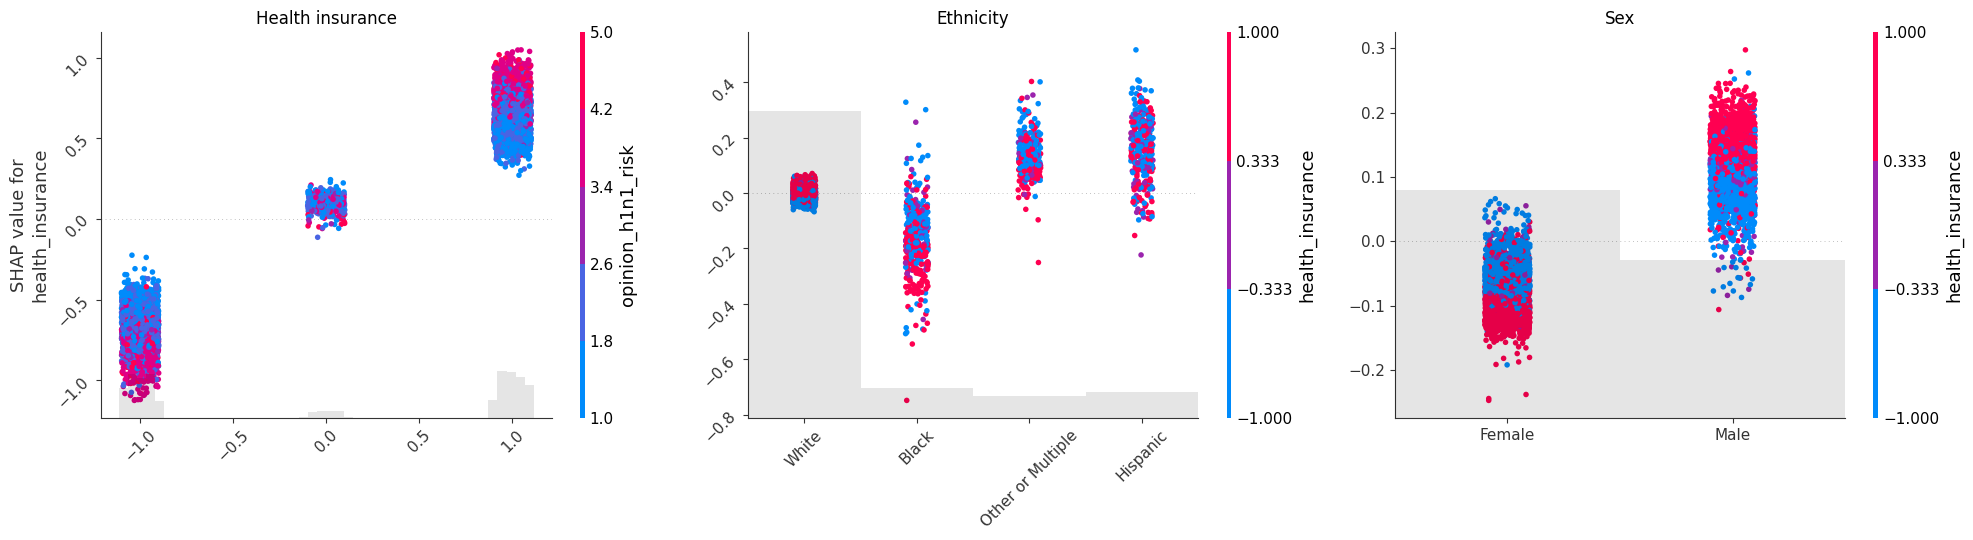

In [ ]:
# make plots colored by each of the top three possible interacting features (might differ for the seasonal and h1n1)
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,5.5))
shap.plots.scatter(h1n1_merged_shap_values[:,"health_insurance"], color=h1n1_merged_shap_values[:,int_h1n1_h[0]], ax=ax[0], show=False)
ax[0].set_title("Health insurance")
ax[0].tick_params(labelrotation= 45)
ax[0].set(xlabel=None)
  
shap.plots.scatter(h1n1_merged_shap_values[:,"race"], color=h1n1_merged_shap_values[:,int_h1n1_e[0]], ax=ax[1], show=False)
ax[1].set_title("Ethnicity")
ax[1].tick_params(labelrotation= 45)
ax[1].set(xlabel=None, ylabel=None)

shap.plots.scatter(h1n1_merged_shap_values[:,"sex"], color=h1n1_merged_shap_values[:,int_h1n1_s[0]], ax=ax[2], show=False)
ax[2].set_title("Sex")
ax[2].tick_params(labelrotation= 0)
ax[2].set(xlabel=None, ylabel=None)
  
# shap.plots.scatter(h1n1_merged_shap_values[:,"sex"], color=h1n1_merged_shap_values[:,int_h1n1_s[0]], ax=ax[3], show=False)
# ax[3].set_title("Sex: H1N1 model")
# ax[3].tick_params(labelrotation= 0)
# ax[3].set(xlabel=None, ylabel=None)

plt.tight_layout()

#### Health insurance

##### Potential interactions

In [ ]:
# we can use shap.potential_interactions to guess which features may interact with age
int_base_h = shap.utils.potential_interactions(base_merged_shap_values[:, "health_insurance"], base_merged_shap_values)
int_h1n1_h = shap.utils.potential_interactions(h1n1_merged_shap_values[:, "health_insurance"], h1n1_merged_shap_values)

In [ ]:
for i in range(5):
  print(base_merged_shap_values.feature_names[int_base_h[i]])

risk_ofgettingsick_withoutvaccine
h1n1_concern
h1n1_knowledge
vaccination_effective
income_poverty


In [ ]:
for i in range(5):
  print(h1n1_merged_shap_values.feature_names[int_h1n1_h[i]])

opinion_h1n1_risk
seasonal_vaccine
opinion_seas_risk
opinion_h1n1_vacc_effective
h1n1_concern


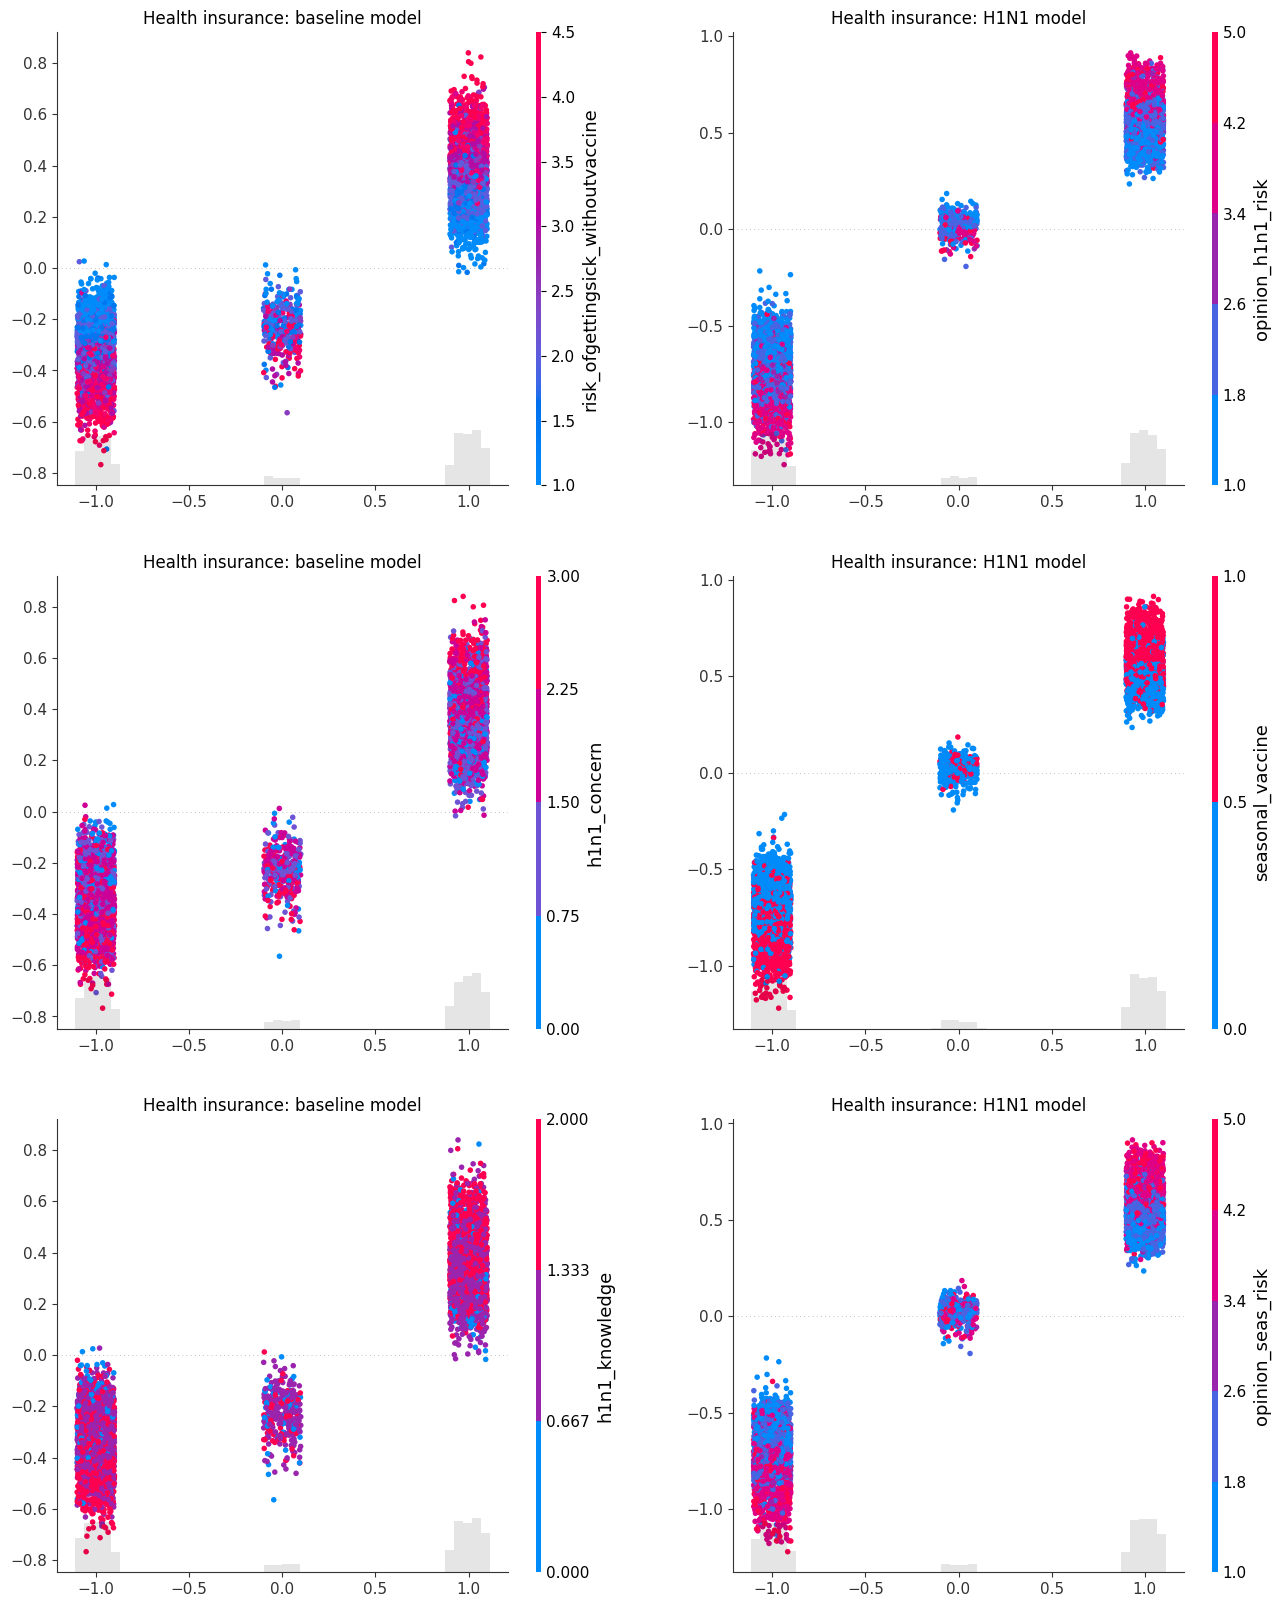

In [ ]:
# make plots colored by each of the top three possible interacting features (might differ for the seasonal and h1n1)
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(16,20))

for r in range(3):
  shap.plots.scatter(base_merged_shap_values[:,"health_insurance"], color=base_merged_shap_values[:,int_base_h[r]], ax=ax[r][0], show=False)
  ax[r][0].set_title("Health insurance: baseline model")
  ax[r][0].set(xlabel=None, ylabel=None)
  
  shap.plots.scatter(h1n1_merged_shap_values[:,"health_insurance"], color=h1n1_merged_shap_values[:,int_h1n1_h[r]], ax=ax[r][1], show=False)
  ax[r][1].set_title("Health insurance: H1N1 model")
  ax[r][1].set(xlabel=None, ylabel=None)
